In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor_PM, MORCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

In [2]:
def apply_overlap(y_train, overlap_ratio):
    N, D = y_train.shape
    indices = np.arange(N)

    # Number of shared (overlap) indices
    n_overlap = int(overlap_ratio * N)

    # Select overlap indices common to all output functions
    shared_indices = np.random.choice(indices, size=n_overlap, replace=False)

    # Initialize all to NaN
    y_obs = np.full_like(y_train, np.nan)

    # Set the shared overlap values
    y_obs[shared_indices, :] = y_train[shared_indices, :]

    # Remaining indices to distribute uniquely across each output
    remaining_indices = np.setdiff1d(indices, shared_indices)

    n_unique_per_output = (N - n_overlap) // D

    for d in range(D):
        # Randomly assign unique indices to each output from remaining pool
        if d < D - 1:
            chosen = np.random.choice(remaining_indices, size=n_unique_per_output, replace=False)
            remaining_indices = np.setdiff1d(remaining_indices, chosen)
        else:
            # Assign all remaining indices to the last output (in case of uneven division)
            chosen = remaining_indices
        y_obs[chosen, d] = y_train[chosen, d]

    return y_obs

## MOGP

[[1.       0.9     ]
 [0.9      1.000096]]


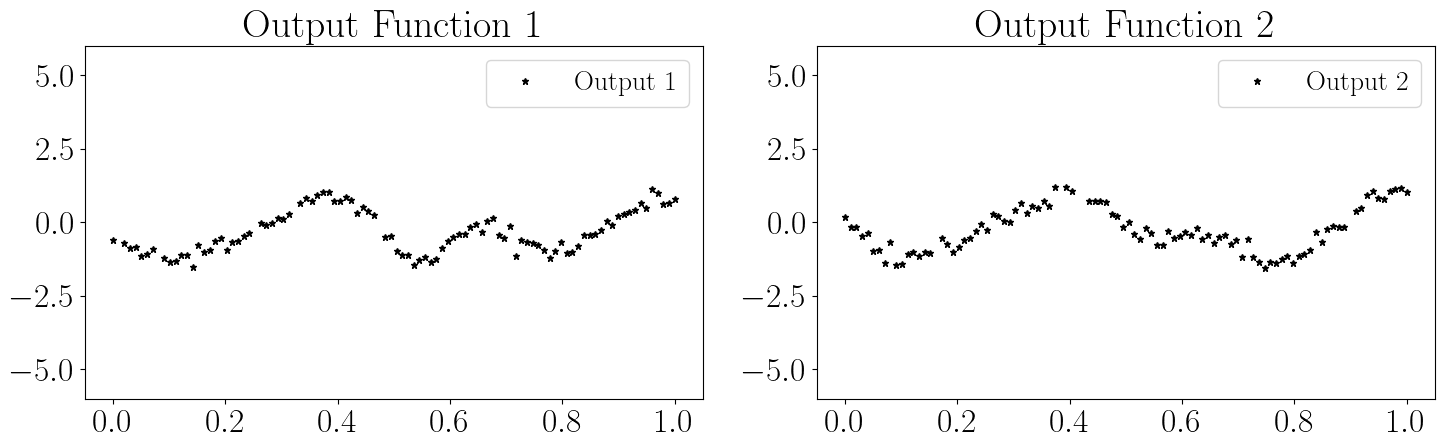

In [6]:
np.random.seed(42)

# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 100
overlap_ratio = 0.9

noise_variance = 0.04

A = np.array([[1, 0], 
              [0.9, 0.436]])
B = A @ A.T
print(B)

D = B.shape[0]

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.linspace(0, 1, n_points).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_variance * np.eye(D), np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

y_train = apply_overlap(y_train, overlap_ratio)

# indices_025 = np.where((x_train >= 0.20) & (x_train <= 0.30))[0]
# outlier_indices_025 = np.random.choice(indices_025, 1, replace=False)
# y_train[outlier_indices_025, 0] = -5

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

37.93123474291687
37.93123477034161
37.93123460211254
37.93123475484034
37.931234740443195
37.93123473063412
37.93123473971485
-4.427403479120191
-4.427403921663682
-4.427402301602553
-4.427403443189444
-4.427403487909466
-4.4274034512962395
-4.427403454072108
39.18515417270429
39.185154173446314
39.18515416105298
39.18515418681891
39.185154169668934
39.18515416257994
39.1851541711897
39.22445983500203
39.22445984010534
39.22445983859737
39.224459844142665
39.224459835232615
39.22445982943543
39.22445983191703
39.2474296980989
39.24742969232942
39.247429704347994
39.247429703756666
39.247429698297005
39.24742969771199
39.24742969761132
39.25487842144887
39.254878427937115
39.254878423106746
39.2548784215679
39.25487842303195
39.25487842515559
39.254878421261395
39.25809766877836
39.258097669567064
39.2580976688048
39.2580976700971
39.25809766949199
39.25809767191987
39.25809766940846
39.26043143681478
39.2604314346743
39.26043143534333
39.260431439040005
39.26043143682958
39.2604314392

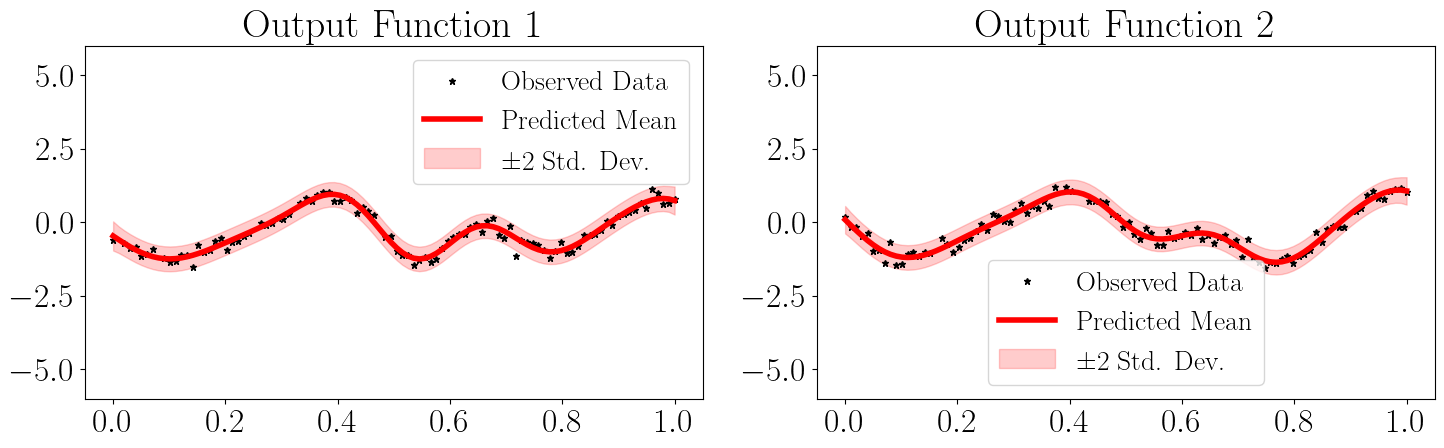

In [7]:
# Instantiate and train
mogp = MOGPRegressor(n_outputs = n_outputs, mean = 0, length_scale=0.1, noise = noise_variance, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
# mogp.optimize_hyperparameters()
mogp.optimize_loo_cv()

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = mogp.predict(x_test)
std = np.sqrt(var + noise_variance)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')
    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

## MORCGP - prior mean

[[1.       0.9     ]
 [0.9      1.000096]]


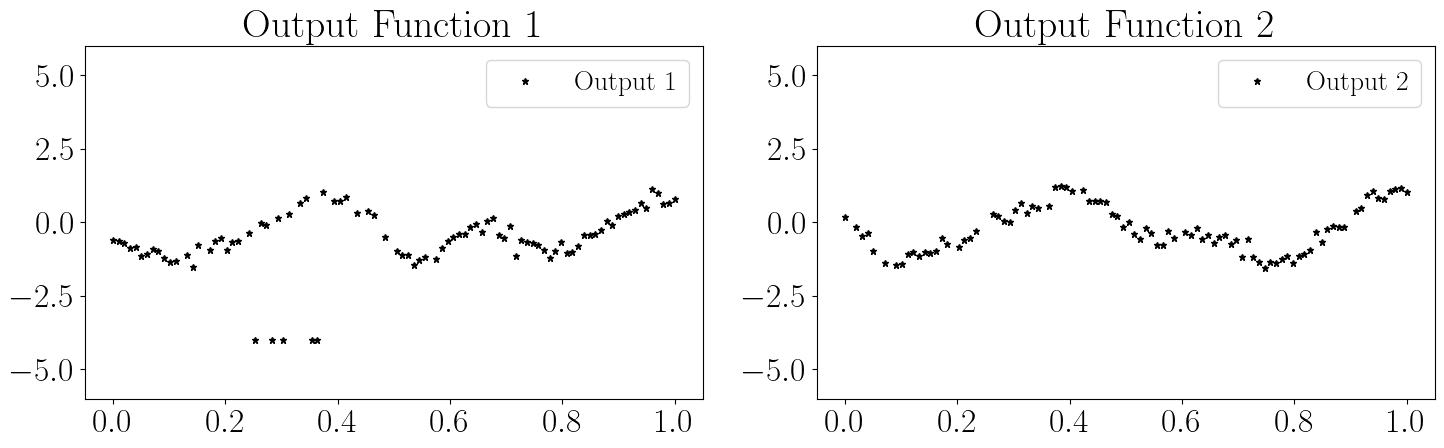

In [7]:
np.random.seed(42)

# Initialisation
constant_mean = 0
epsilon = 0.05
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 100
overlap_ratio = 0.8

noise_variance = 0.04

A = np.array([[1, 0], 
              [0.9, 0.436]])
B = A @ A.T
print(B)

D = B.shape[0]

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.linspace(0, 1, n_points).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_variance * np.eye(D), np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

y_train = apply_overlap(y_train, overlap_ratio)

indices_025 = np.where((x_train >= 0.20) & (x_train <= 0.40))[0]
outlier_indices_025 = np.random.choice(indices_025, int(epsilon * n_points), replace=False)
y_train[outlier_indices_025, 0] = -4

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

In [8]:
# Instantiate and train
morcgp = MORCGPRegressor_PM(n_outputs = n_outputs, mean = 0, length_scale=0.1, noise = noise_variance, A=A, epsilon = epsilon)
morcgp.fit(x_train, y_train)

# # Optimize hyperparameters
# mogp.optimize_hyperparameters()

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = morcgp.predict(x_test)
std = np.sqrt(var + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')
    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

AttributeError: 'int' object has no attribute 'reshape'

## MORCGP - cross channel predictive

[[1.999396 1.200486]
 [1.200486 1.000642]]


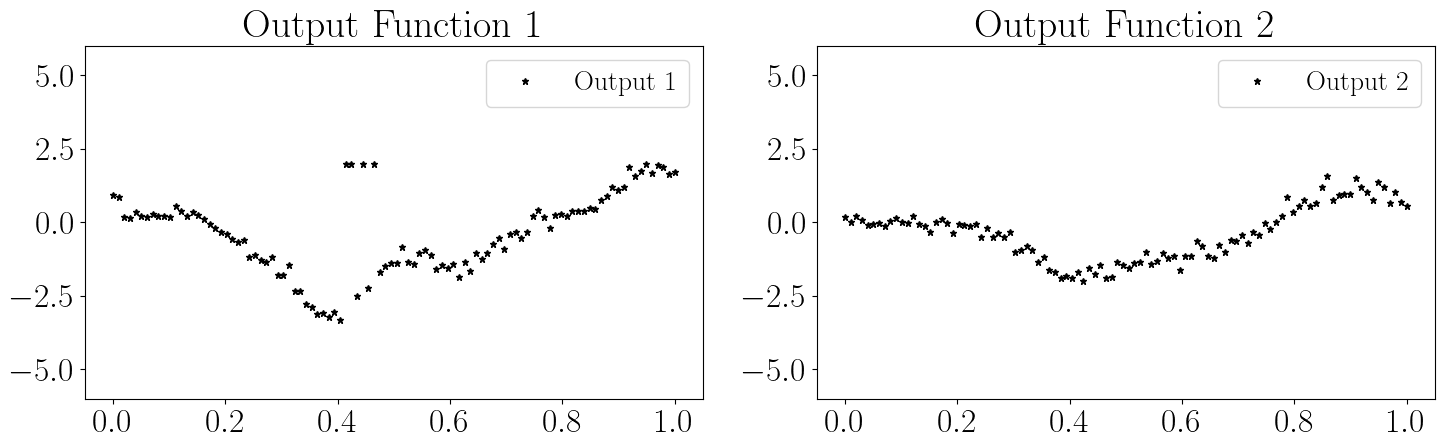

In [9]:
np.random.seed(10)

# Initialisation
constant_mean = 0
length_scale = 0.1
variance = 1
n_outputs = 2
n_points = 100
overlap_ratio = 1

noise_variance = 0.04

A = np.array([[1.414, 0], 
    [0.849, 0.529]])
B = A @ A.T
print(B)

D = B.shape[0]

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.linspace(0, 1, n_points).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_variance * np.eye(D), np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

y_train = apply_overlap(y_train, overlap_ratio)

indices_025 = np.where((x_train >= 0.40) & (x_train <= 0.50))[0]
outlier_indices_025 = np.random.choice(indices_025, int(4), replace=False)
y_train[outlier_indices_025, 0] = 2

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

In [10]:
# Instantiate and train
mogp = MOGPRegressor(n_outputs = n_outputs, mean = 0, length_scale=0.1, noise = noise_variance, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_B = mogp.B
print(optim_B)

Optimized length_scale: 0.0551, noise: 0.282719
Optimized A: [[ 1.18693867 -0.04985426]
 [ 0.57501485  0.44924097]]
Optimized B: 
[[1.41130885 0.66011078]
 [0.66011078 0.53245952]]
[[1.41130885 0.66011078]
 [0.66011078 0.53245952]]


13.320377656542457
13.320377556786566
13.32037739497029
13.320377685932556
13.320377719073727
13.320377667638157
13.320377559311359
9.552603331566766
9.552603347264887
9.55260325563223
9.552603362701873
9.552602600472119
9.552603271108904
9.552604571686901
20.657897367100304
20.65789744454076
20.65789721380781
20.657897306571762
20.65789724431998
20.65789742485929
20.657897592649224
20.30622028531083
20.30622039187667
20.30622044644838
20.306220137077634
20.30622061347923
20.306220461267976
20.306219850645
22.615727015343264
22.61572711290792
22.61572699392038
22.61572692082346
22.615727094427246
22.615727117968692
22.615726927090492
23.569098000192376
23.56909808484405
23.56909798632381
23.569097918532787
23.56909805187812
23.569098071338352
23.569097943361555
24.70222401075014
24.70222401354321
24.702223960825908
24.702224075837616
24.70222391409412
24.70222389658979
24.702224104701333
24.906186508660028
24.90618652299462
24.90618651197166
24.906186473827734
24.906186539742883
24.906

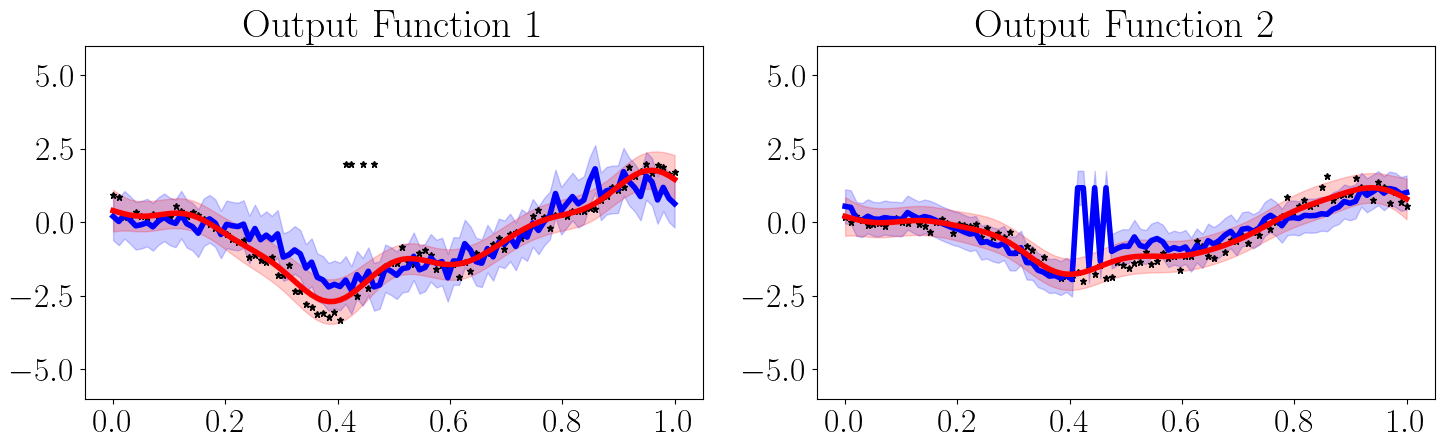

In [11]:
# Instantiate and train
morcgp = MORCGPRegressor(n_outputs = n_outputs, mean = 0, length_scale=0.1, noise = noise_variance, A=A)
predictive_mean, predictive_variances = morcgp.fit(x_train, y_train)

# print(morcgp.loo_cv(length_scale=0.1, noise=0.04, A=A, weighted=True, B_weighted=B))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True, B_weighted=optim_B)


# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = morcgp.predict(x_test)
std = np.sqrt(var + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    axs[i].fill_between(x_test.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

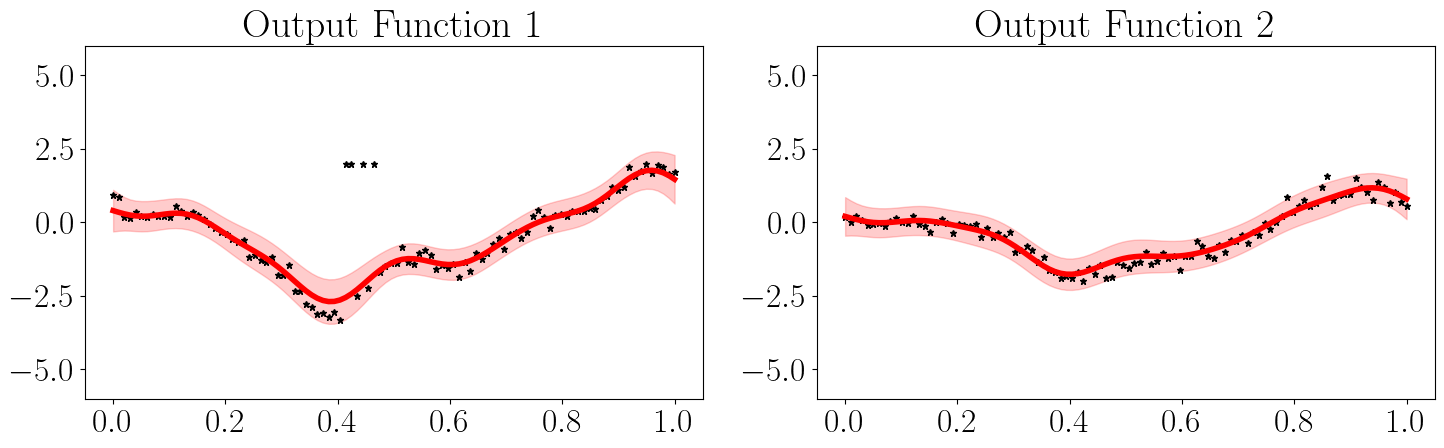

In [13]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    # axs[i].plot(x_train.flatten(), ((morcgp.weights_01.reshape(n_outputs,-1).T))[:,i], '_', color='red', label=f'Predictive Mean', markersize=10)

    # axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x_test.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

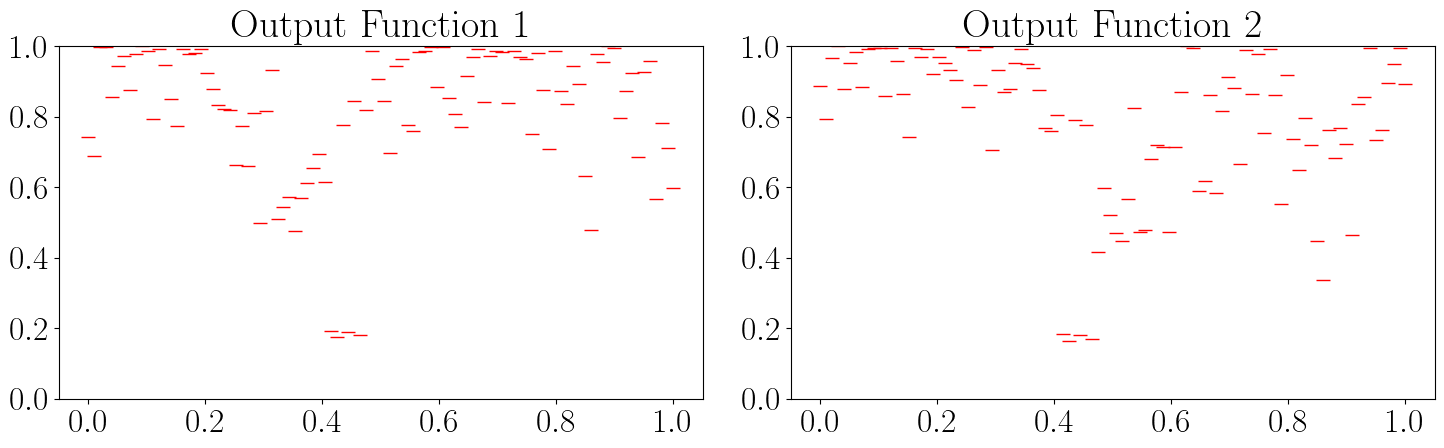

In [12]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):

    axs[i].plot(x_train.flatten(), ((morcgp.weights_01.reshape(n_outputs,-1).T))[:,i], '_', color='red', label=f'Predictive Mean', markersize=10)

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([0, 1])

plt.tight_layout()
plt.show()

## Plot

0
[[1.999396 1.200486]
 [1.200486 1.000642]]


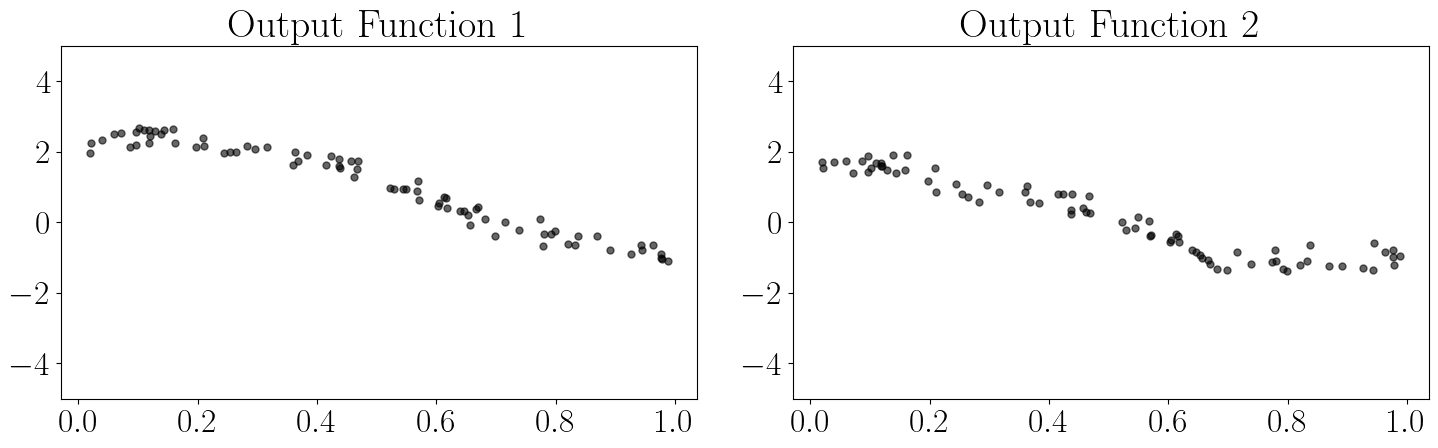

1
[[1.999396 1.200486]
 [1.200486 1.000642]]


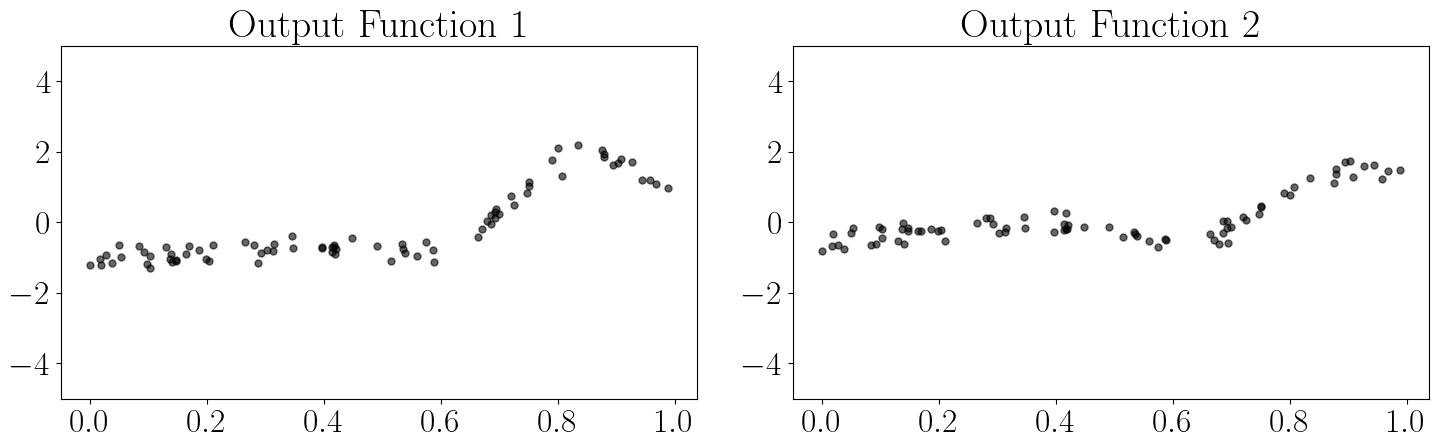

2
[[1.999396 1.200486]
 [1.200486 1.000642]]


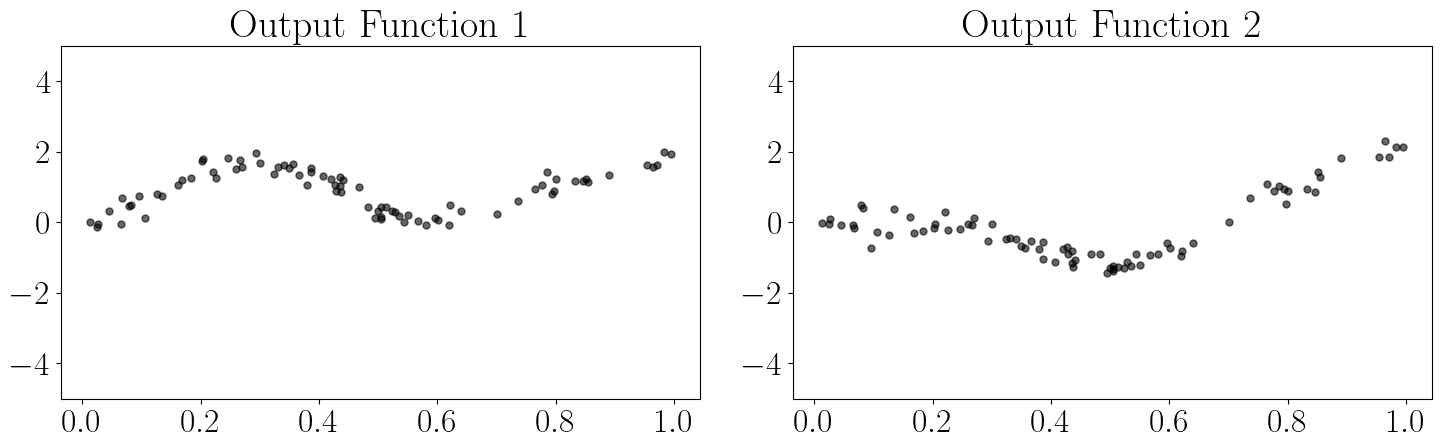

3
[[1.999396 1.200486]
 [1.200486 1.000642]]


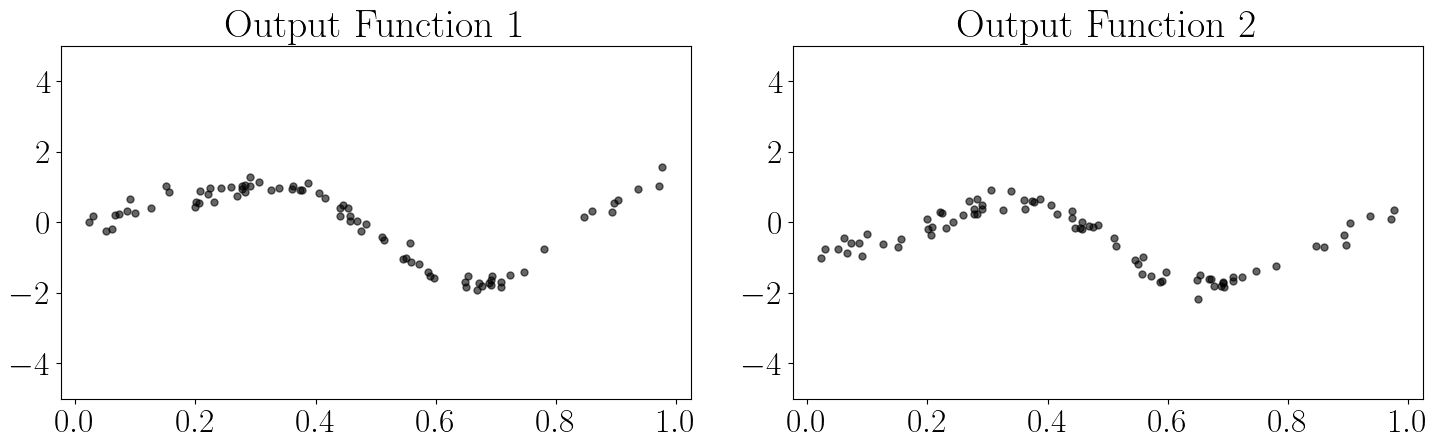

4
[[1.999396 1.200486]
 [1.200486 1.000642]]


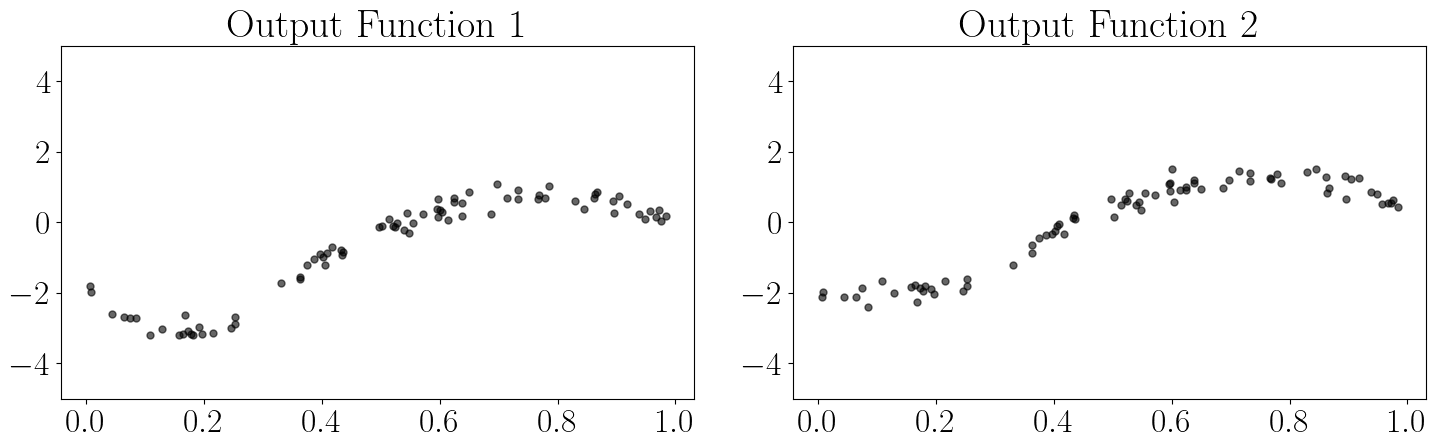

5
[[1.999396 1.200486]
 [1.200486 1.000642]]


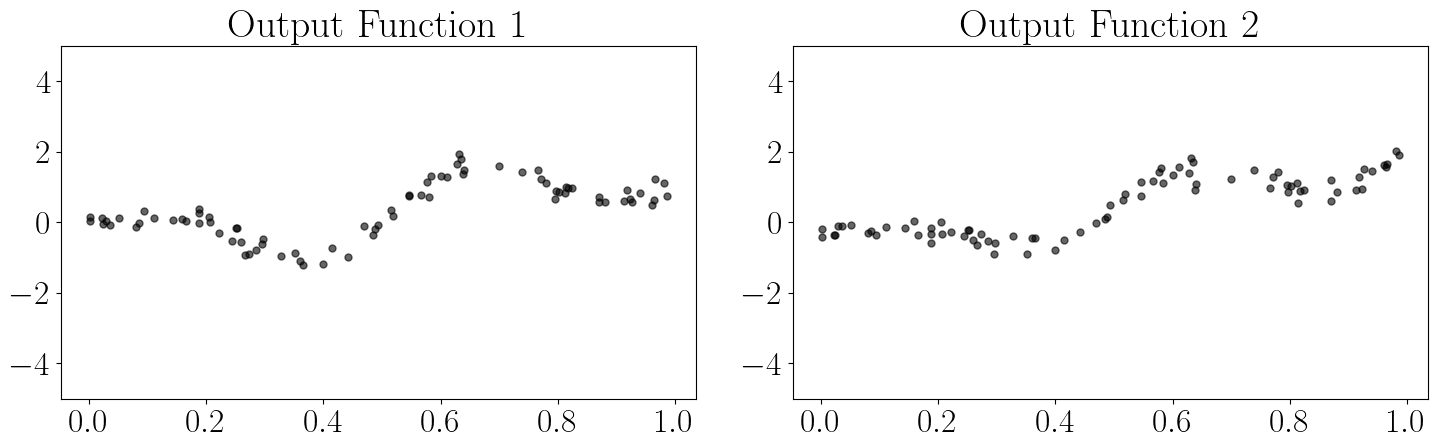

6
[[1.999396 1.200486]
 [1.200486 1.000642]]


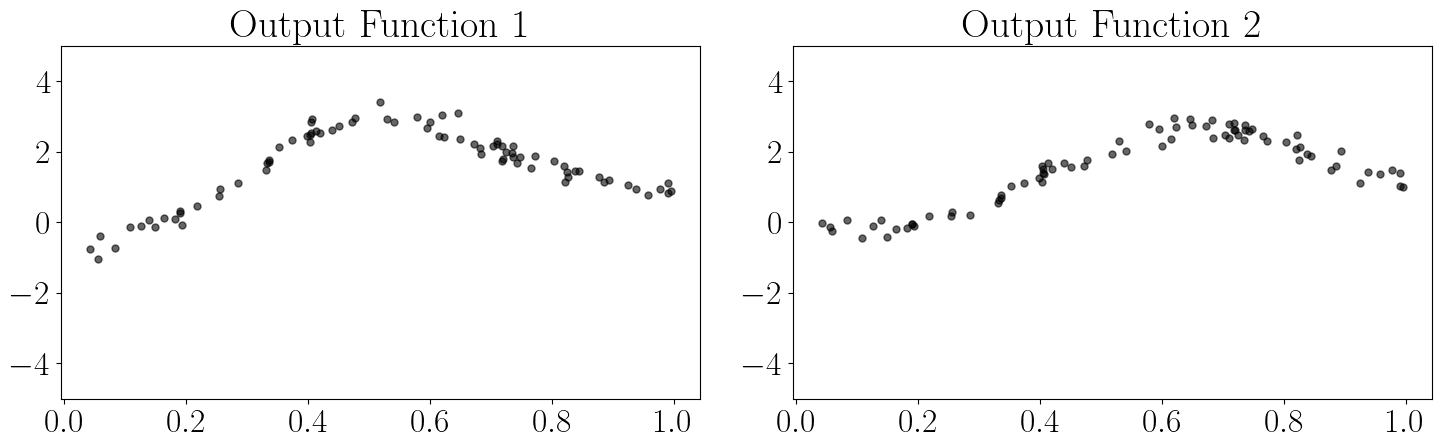

7
[[1.999396 1.200486]
 [1.200486 1.000642]]


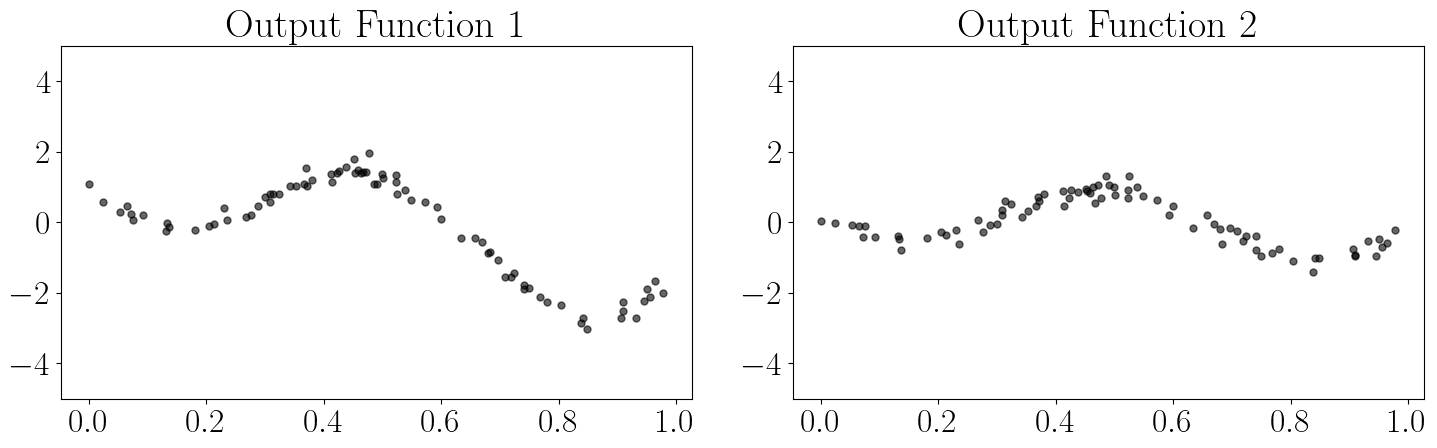

8
[[1.999396 1.200486]
 [1.200486 1.000642]]


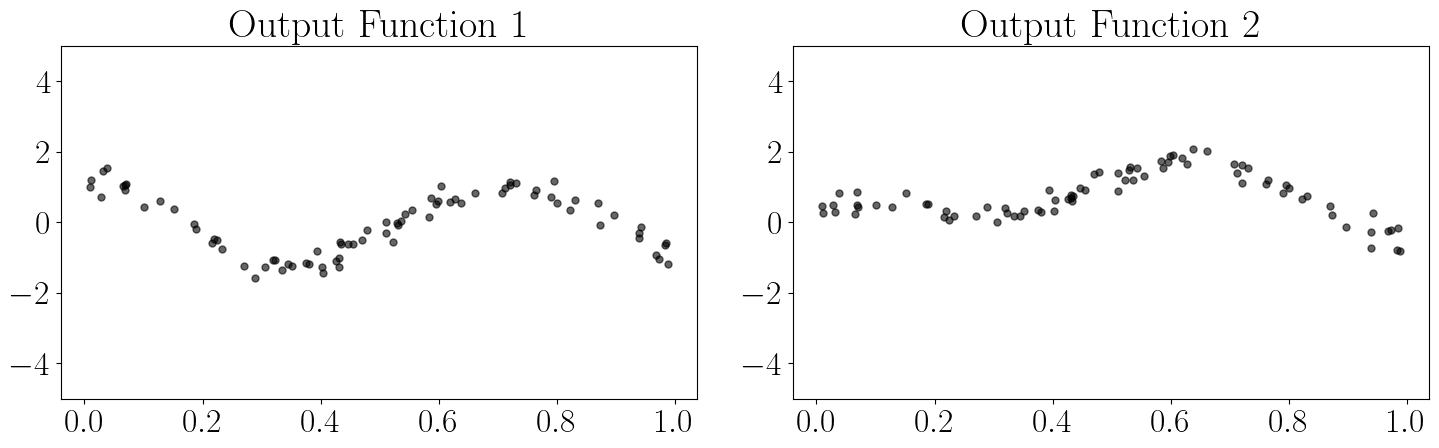

9
[[1.999396 1.200486]
 [1.200486 1.000642]]


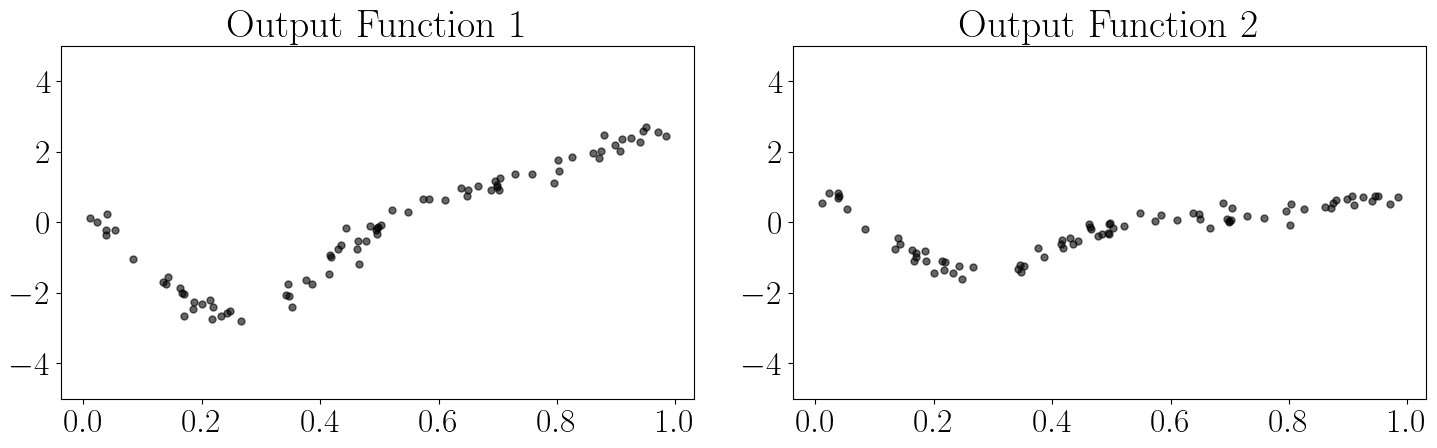

10
[[1.999396 1.200486]
 [1.200486 1.000642]]


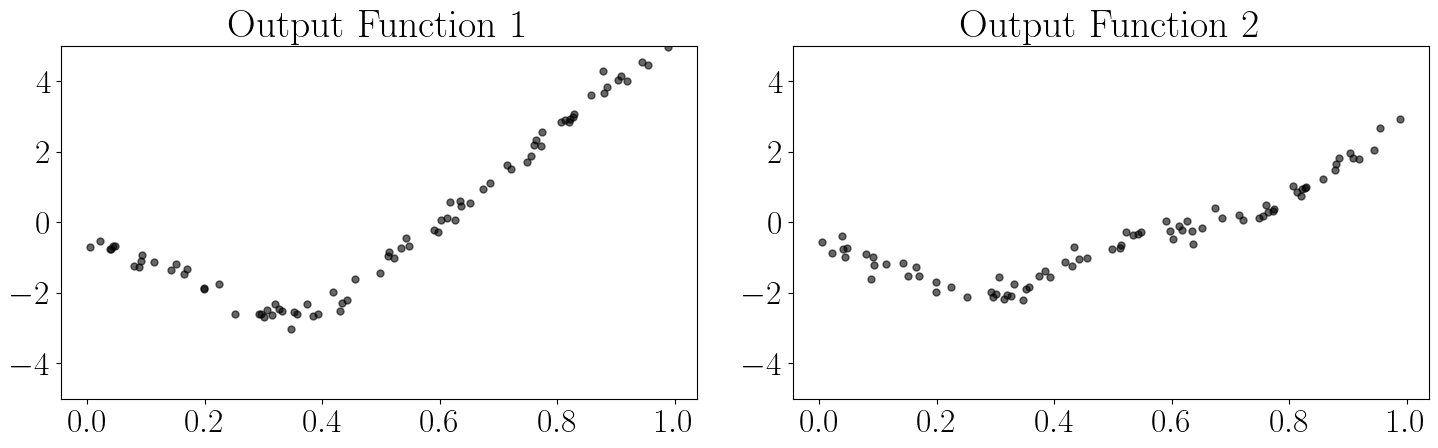

11
[[1.999396 1.200486]
 [1.200486 1.000642]]


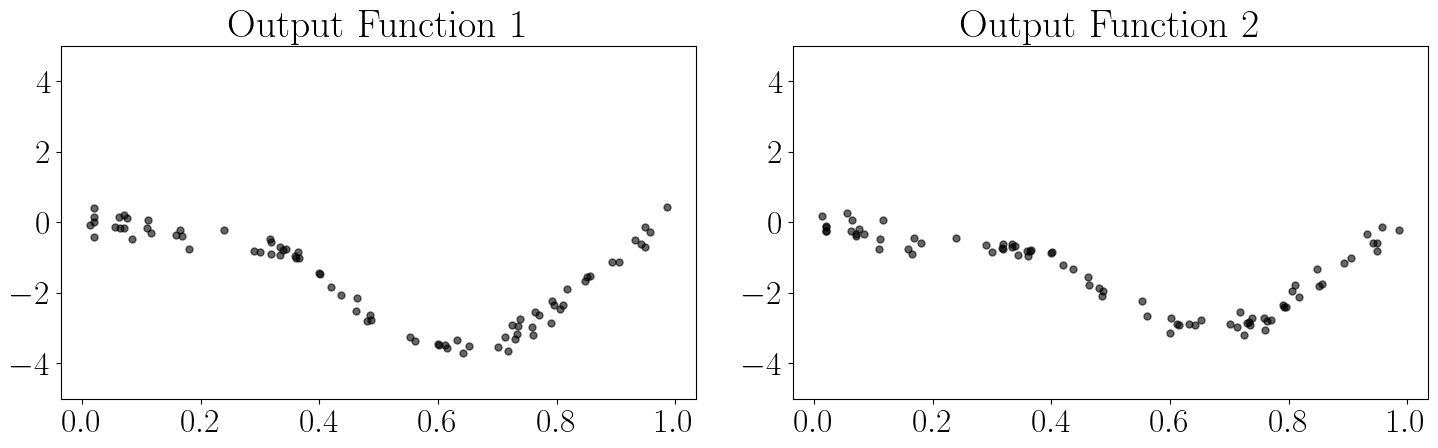

12
[[1.999396 1.200486]
 [1.200486 1.000642]]


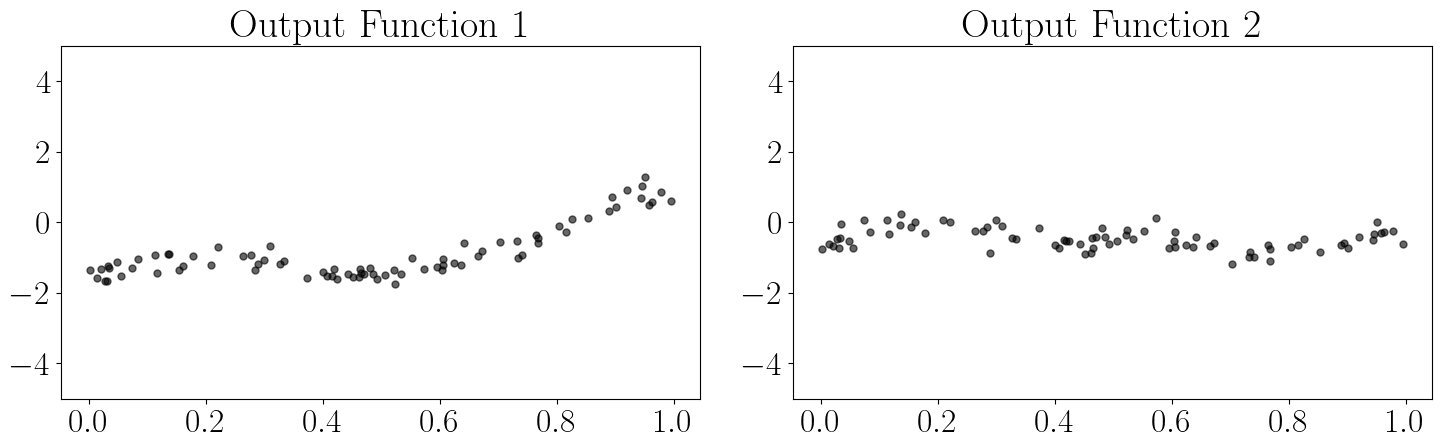

13
[[1.999396 1.200486]
 [1.200486 1.000642]]


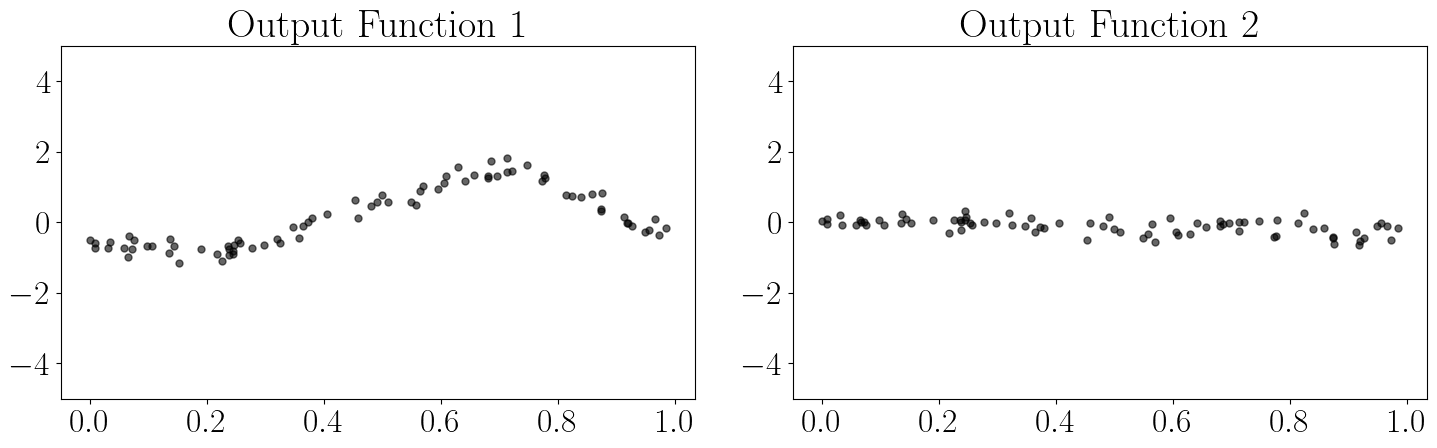

14
[[1.999396 1.200486]
 [1.200486 1.000642]]


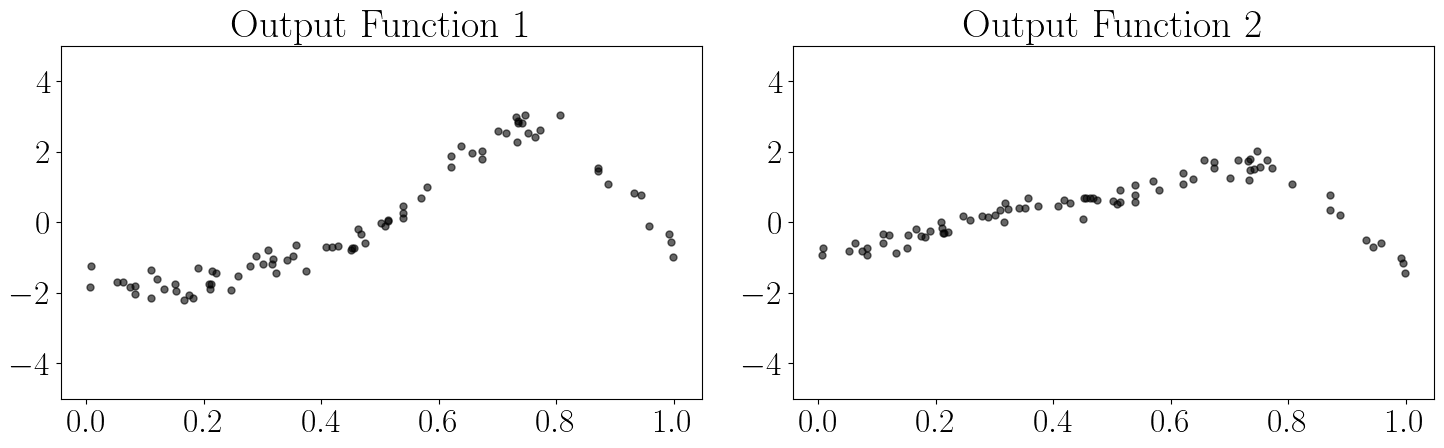

15
[[1.999396 1.200486]
 [1.200486 1.000642]]


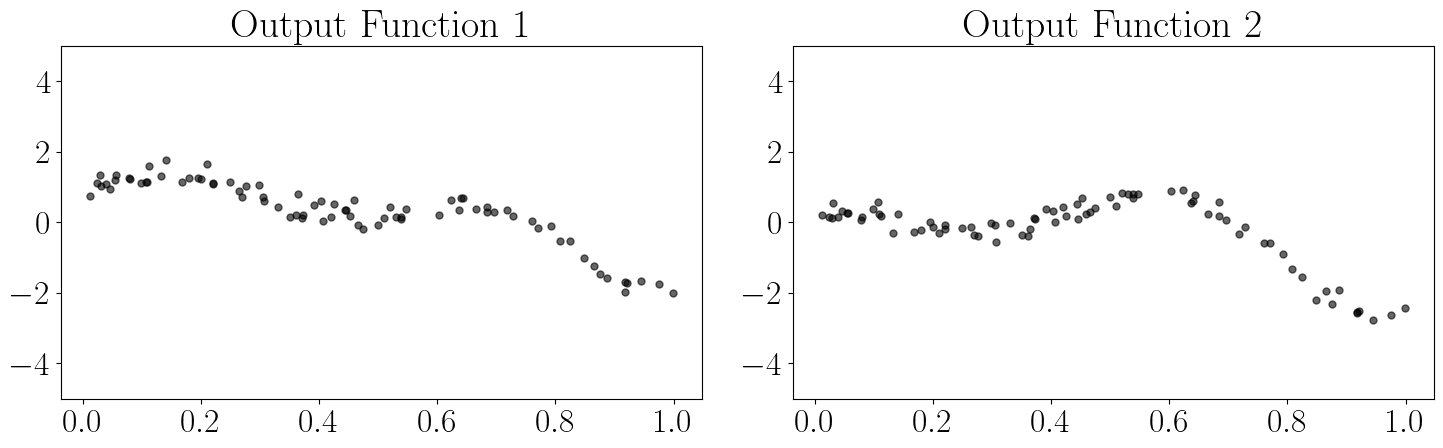

16
[[1.999396 1.200486]
 [1.200486 1.000642]]


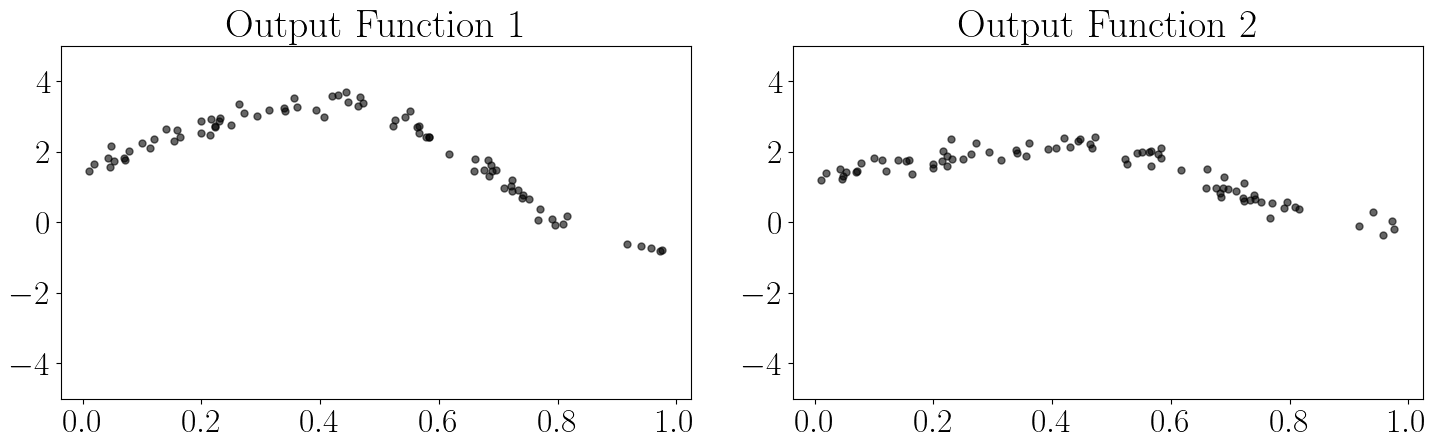

17
[[1.999396 1.200486]
 [1.200486 1.000642]]


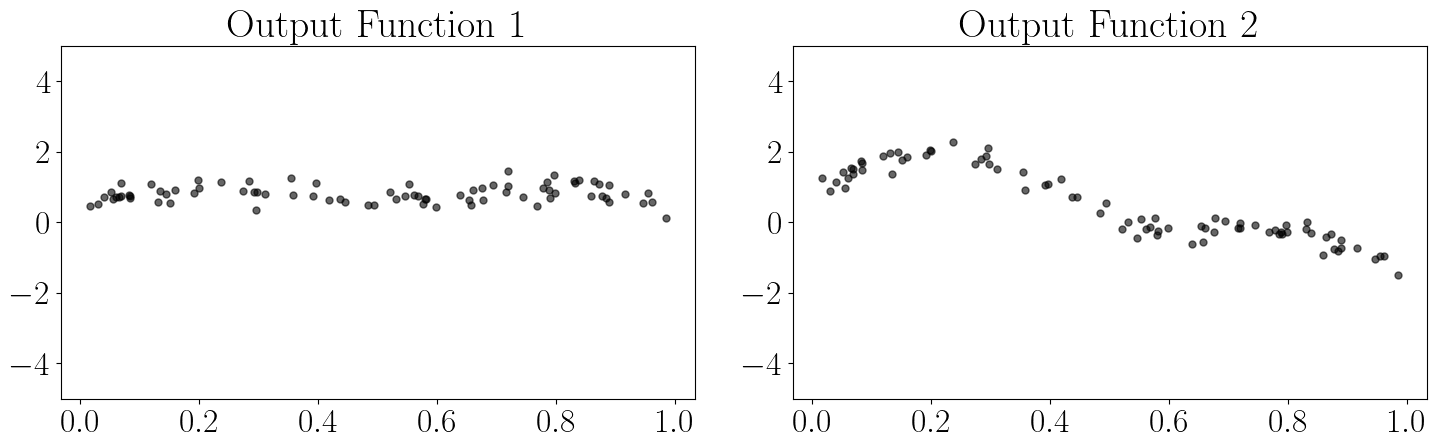

18
[[1.999396 1.200486]
 [1.200486 1.000642]]


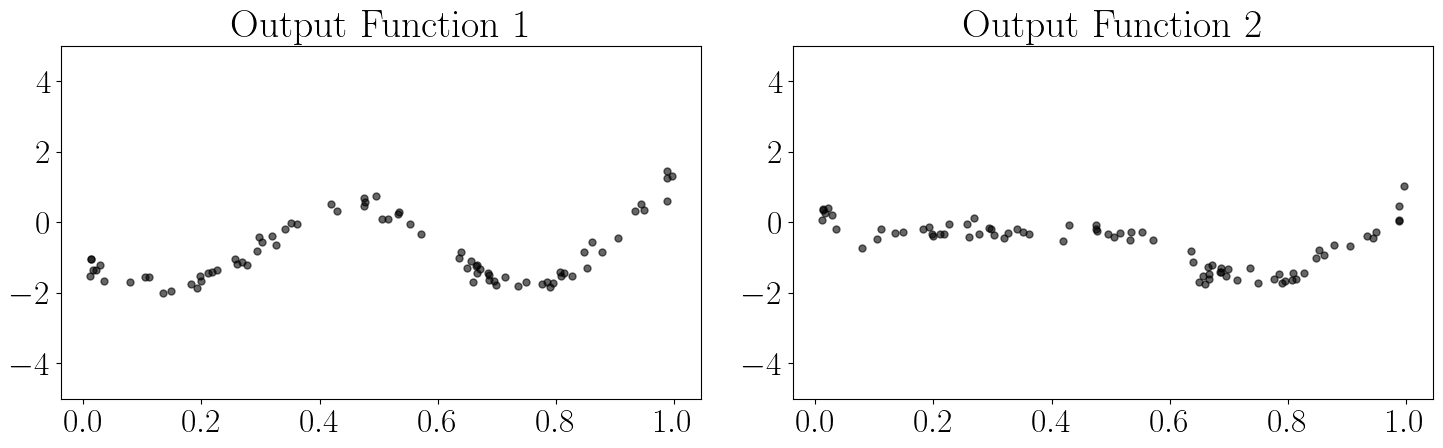

19
[[1.999396 1.200486]
 [1.200486 1.000642]]


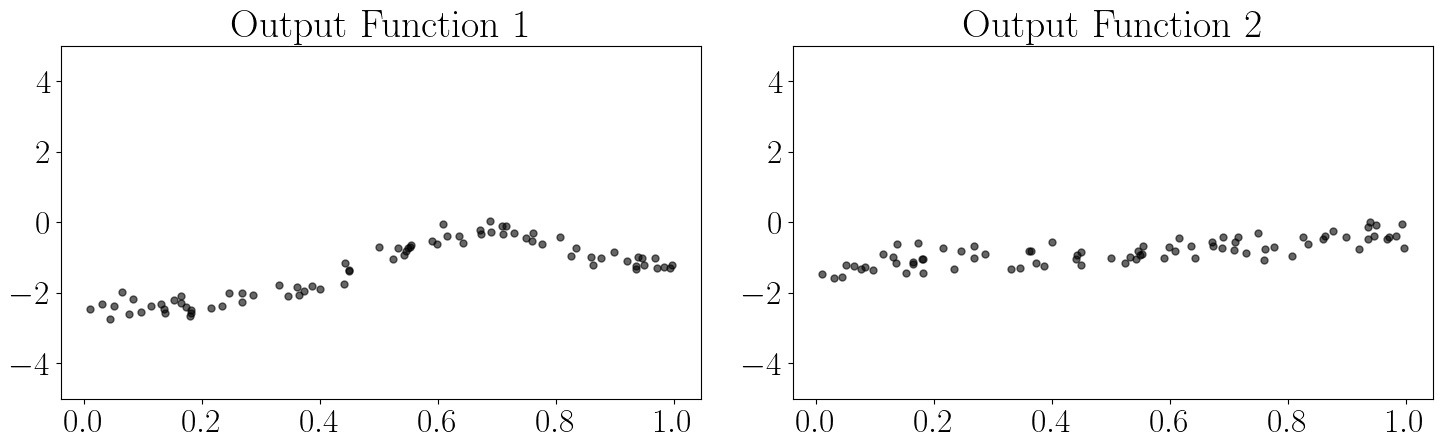

20
[[1.999396 1.200486]
 [1.200486 1.000642]]


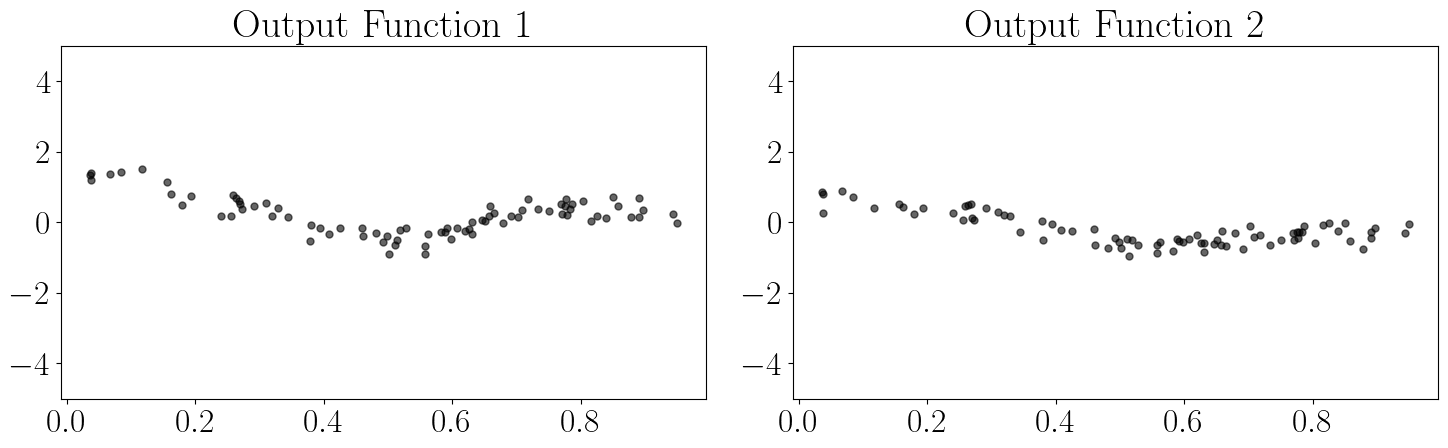

21
[[1.999396 1.200486]
 [1.200486 1.000642]]


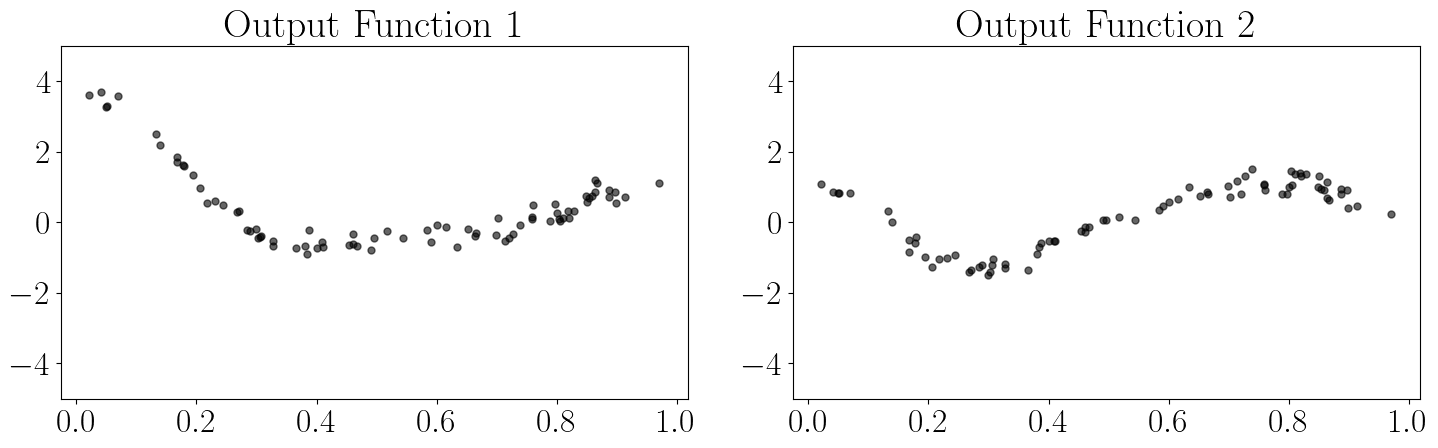

22
[[1.999396 1.200486]
 [1.200486 1.000642]]


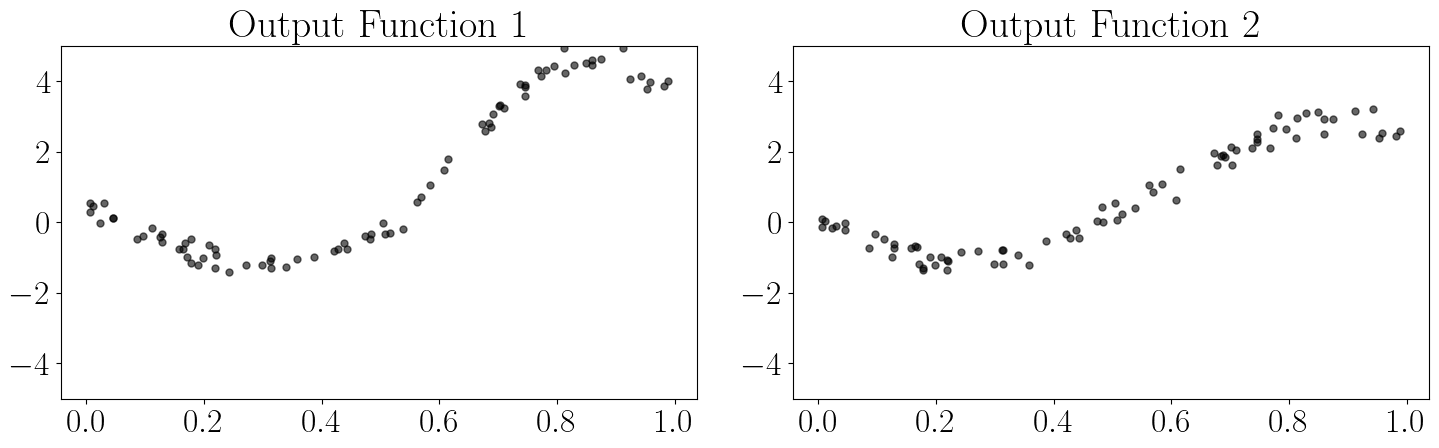

23
[[1.999396 1.200486]
 [1.200486 1.000642]]


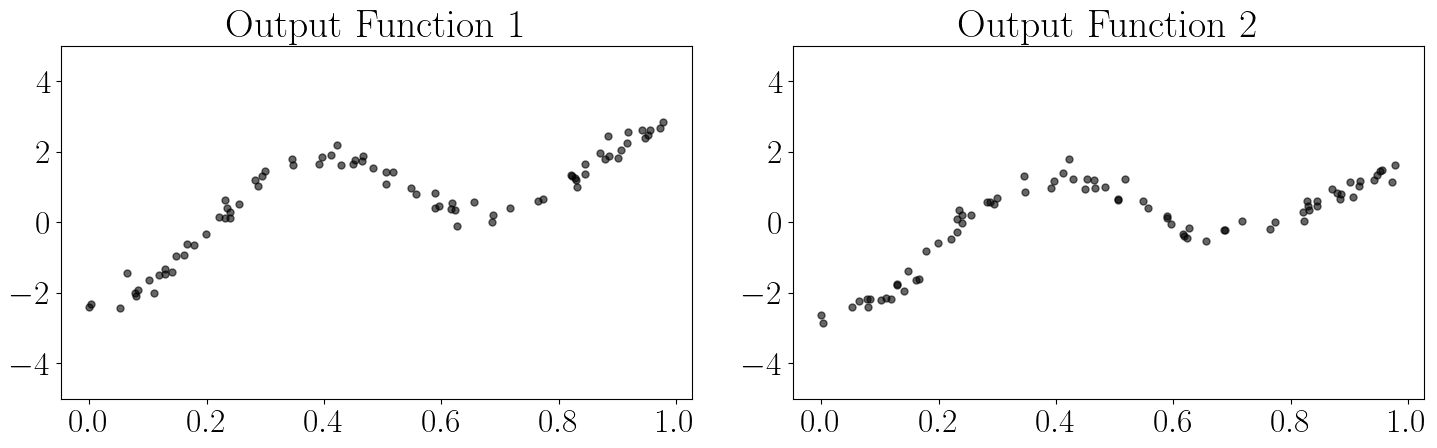

24
[[1.999396 1.200486]
 [1.200486 1.000642]]


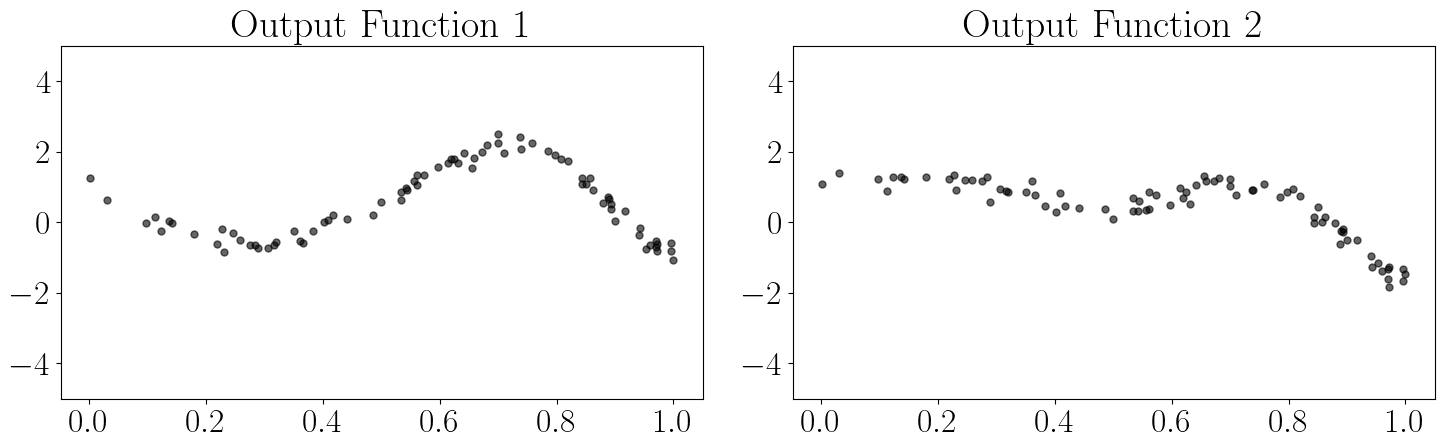

25
[[1.999396 1.200486]
 [1.200486 1.000642]]


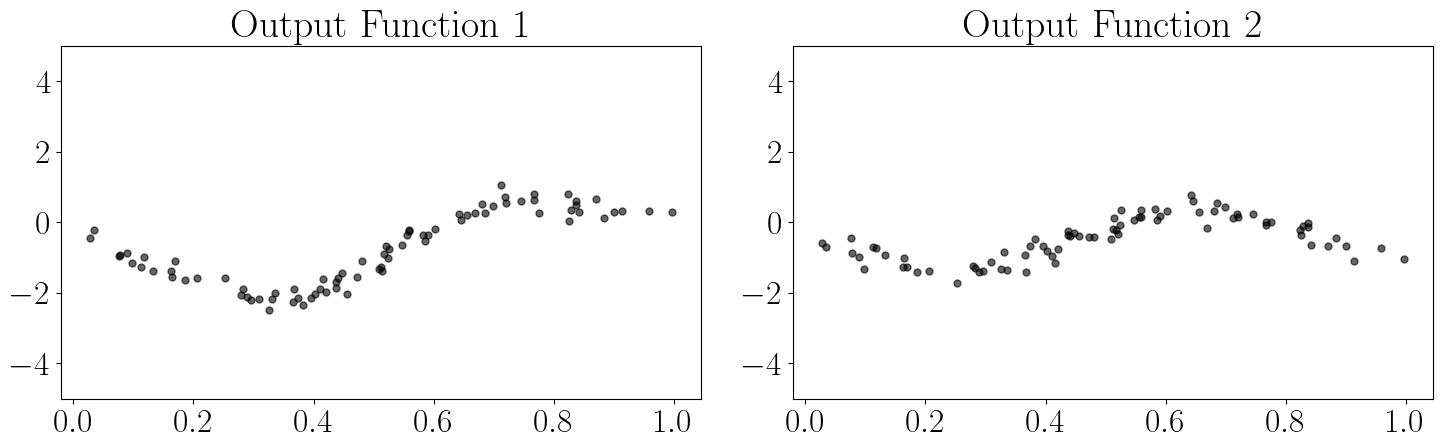

26
[[1.999396 1.200486]
 [1.200486 1.000642]]


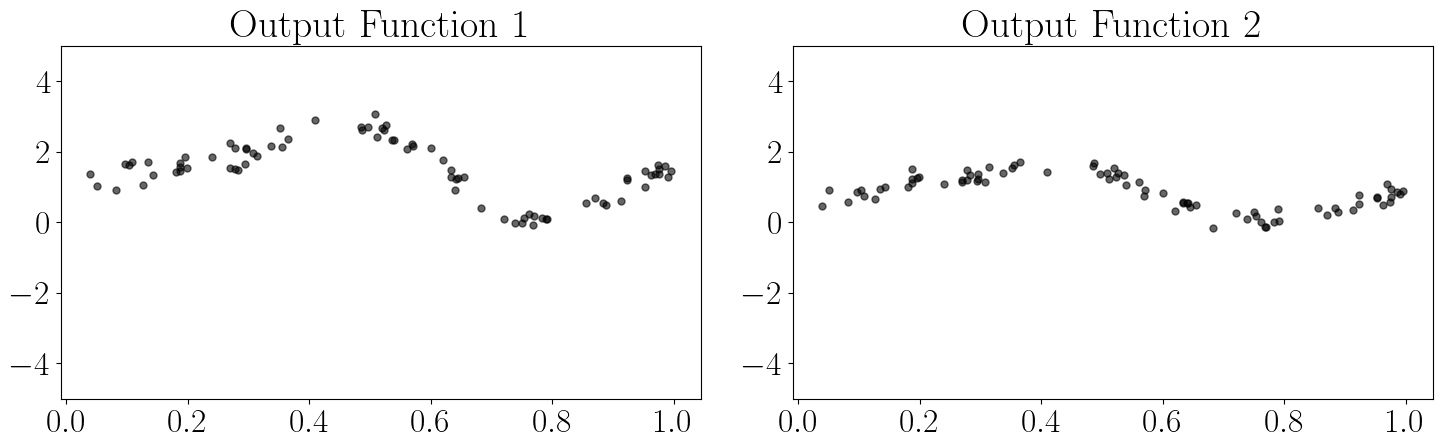

27
[[1.999396 1.200486]
 [1.200486 1.000642]]


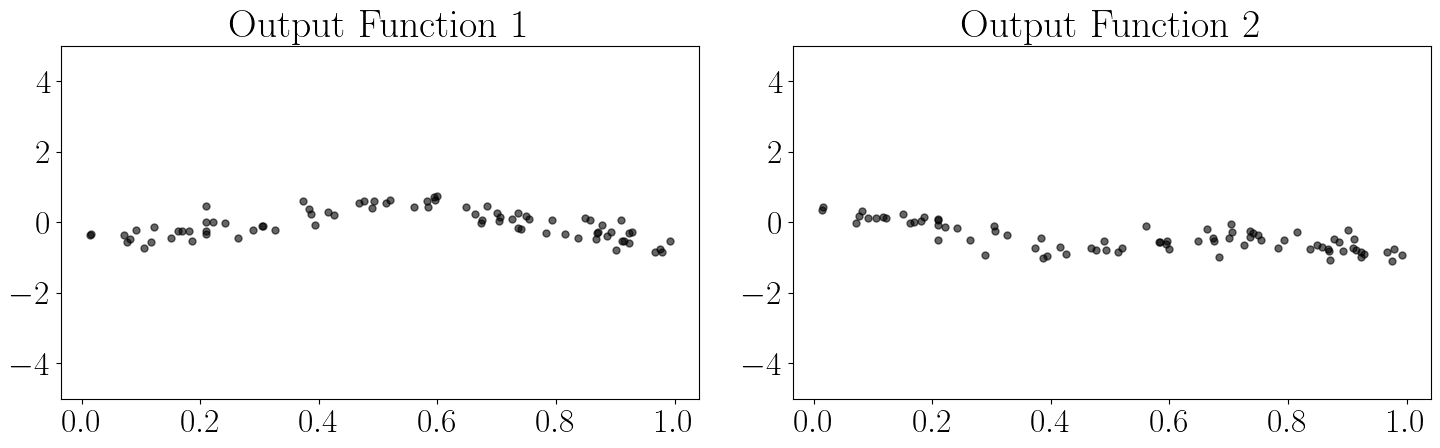

28
[[1.999396 1.200486]
 [1.200486 1.000642]]


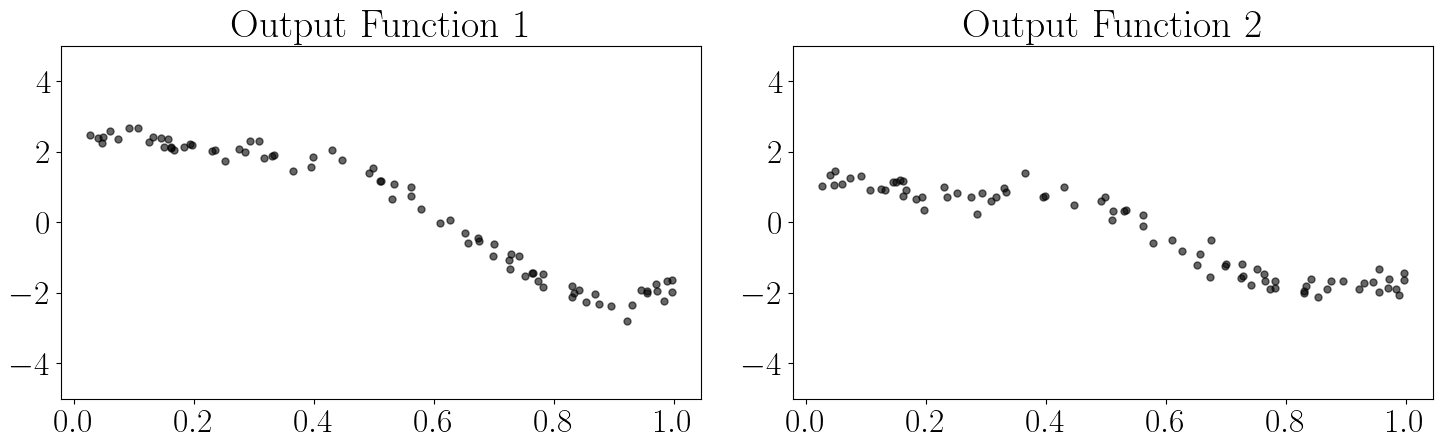

29
[[1.999396 1.200486]
 [1.200486 1.000642]]


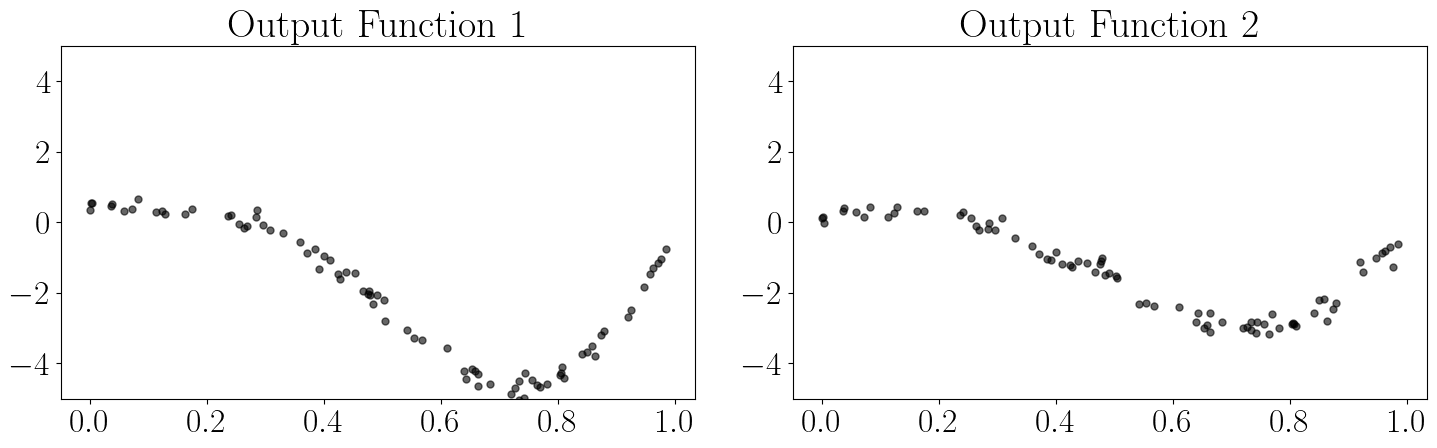

30
[[1.999396 1.200486]
 [1.200486 1.000642]]


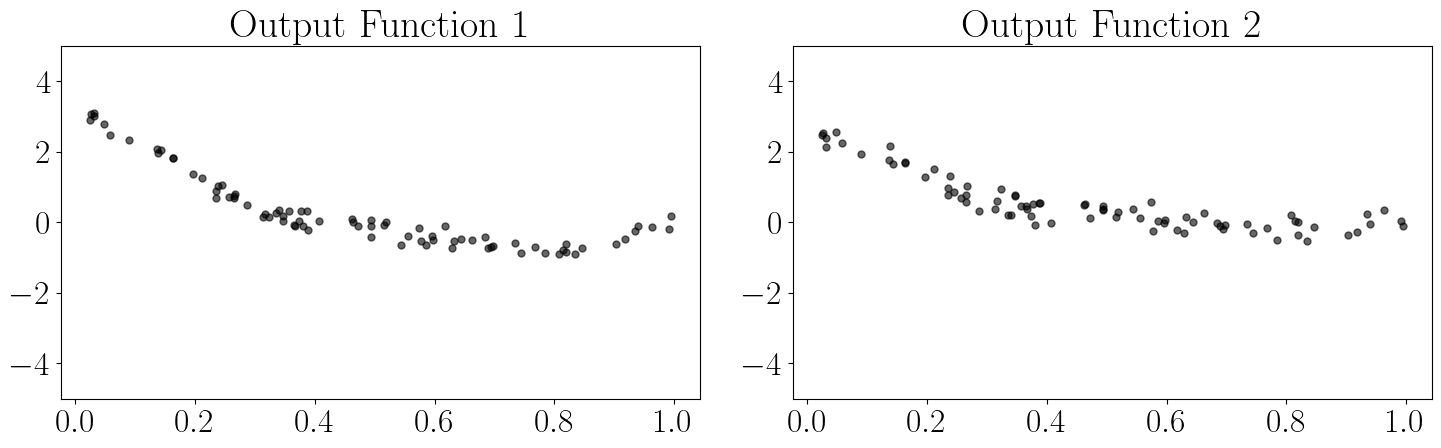

31
[[1.999396 1.200486]
 [1.200486 1.000642]]


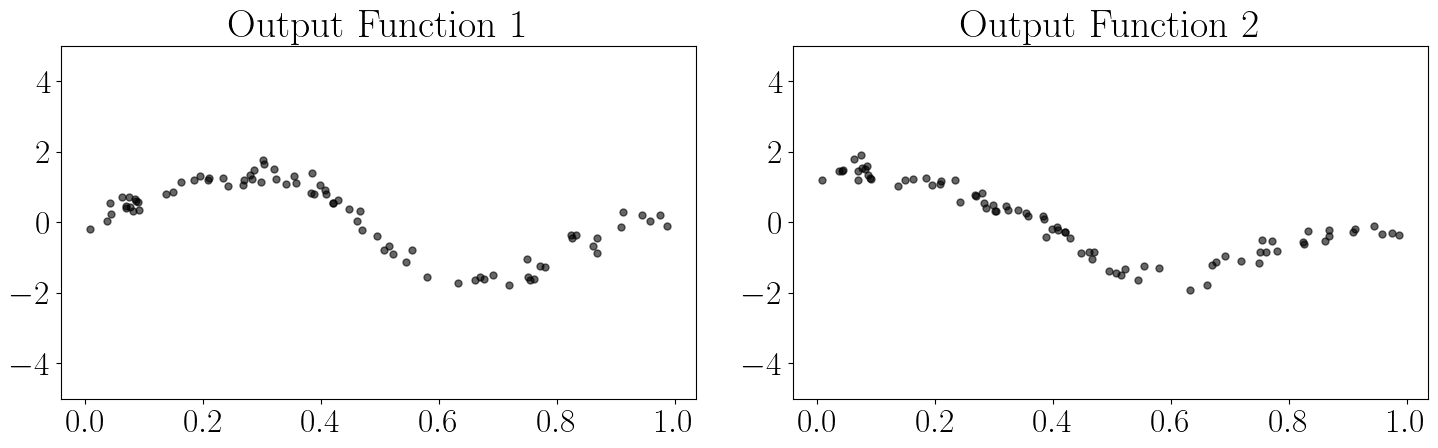

32
[[1.999396 1.200486]
 [1.200486 1.000642]]


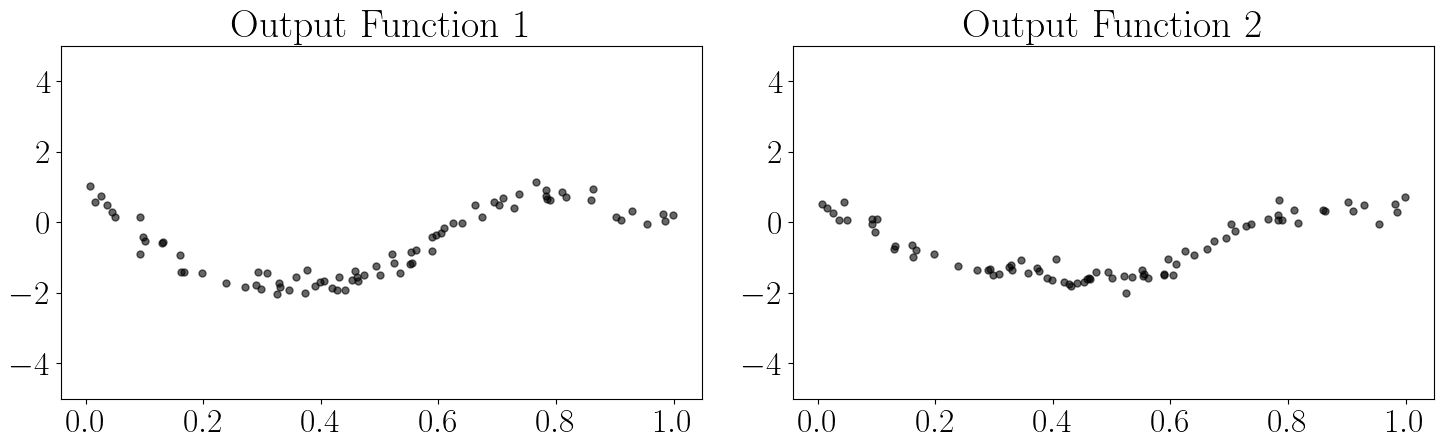

33
[[1.999396 1.200486]
 [1.200486 1.000642]]


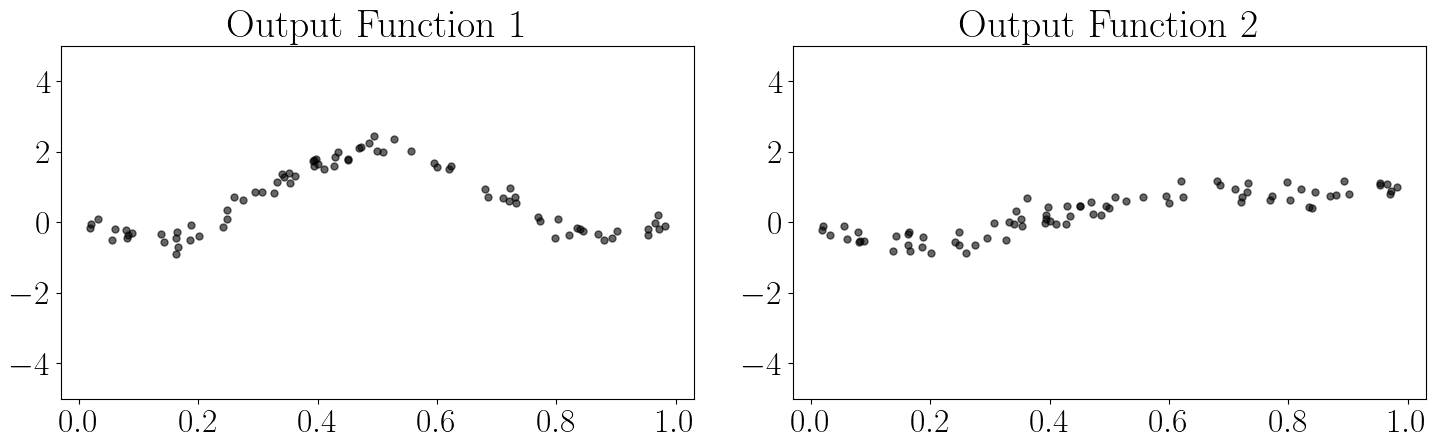

34
[[1.999396 1.200486]
 [1.200486 1.000642]]


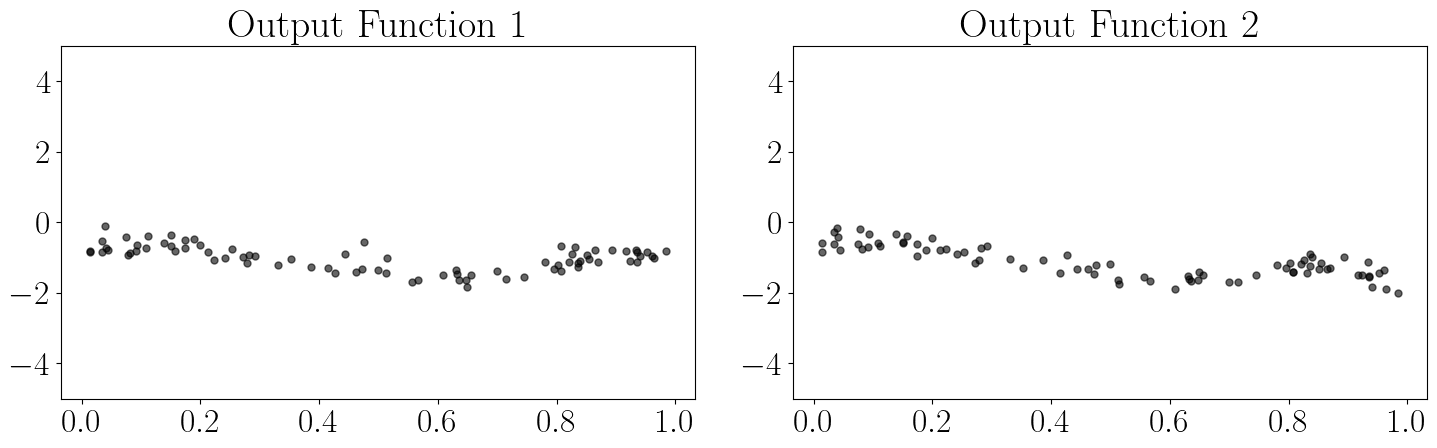

35
[[1.999396 1.200486]
 [1.200486 1.000642]]


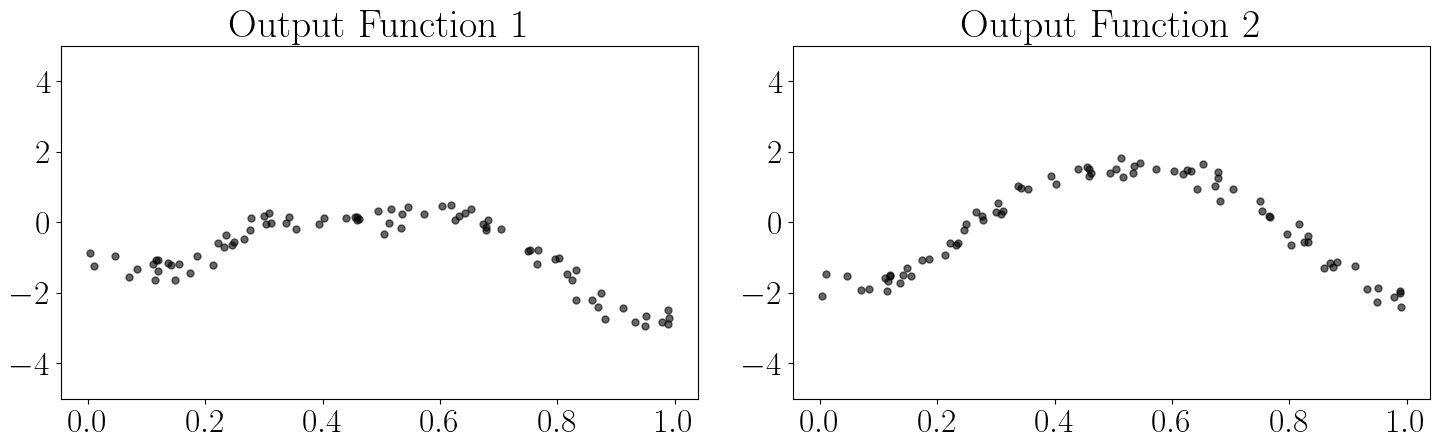

36
[[1.999396 1.200486]
 [1.200486 1.000642]]


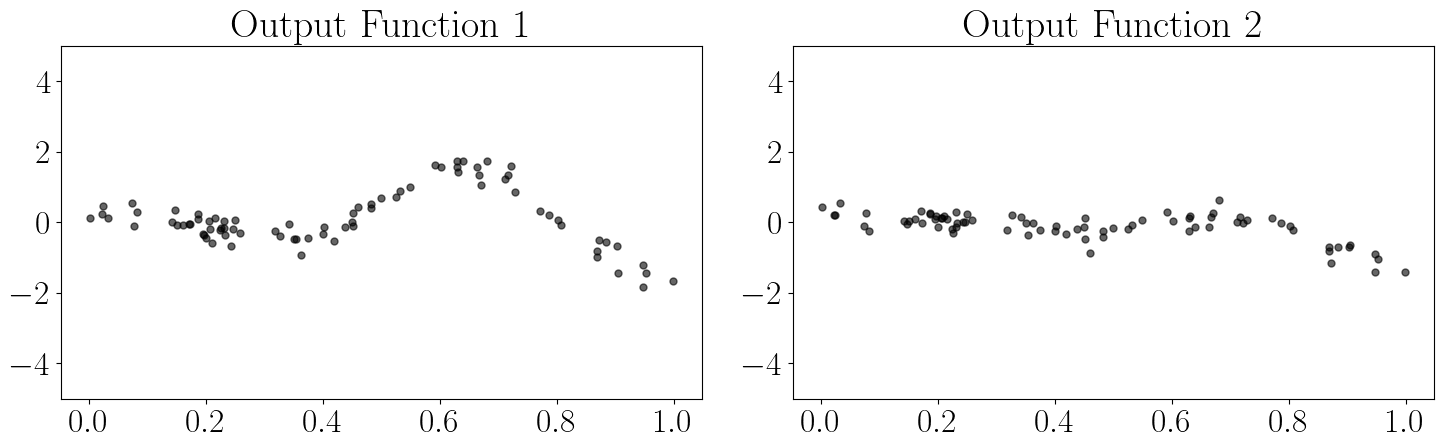

37
[[1.999396 1.200486]
 [1.200486 1.000642]]


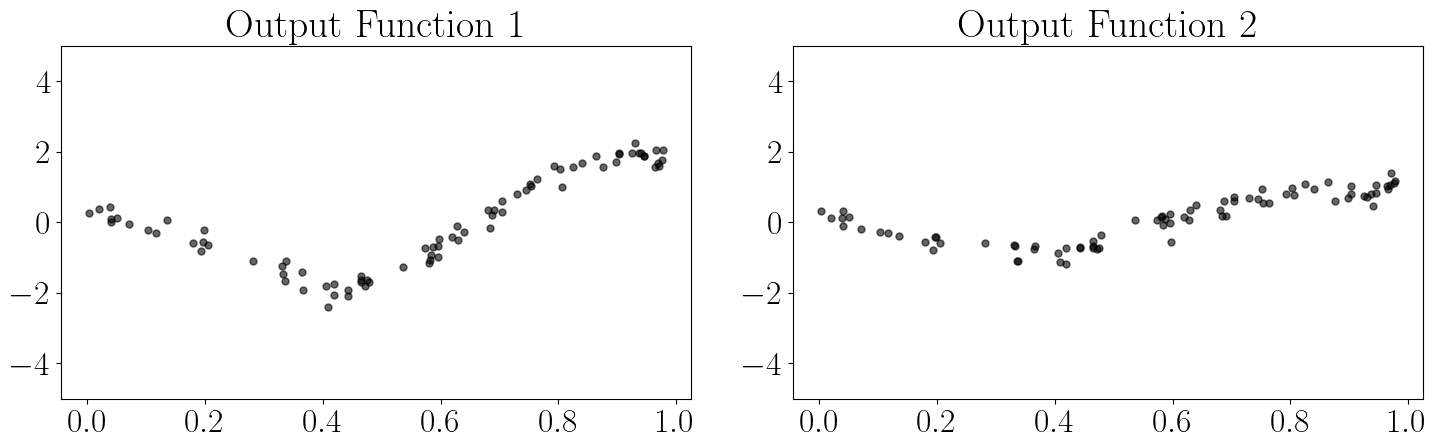

38
[[1.999396 1.200486]
 [1.200486 1.000642]]


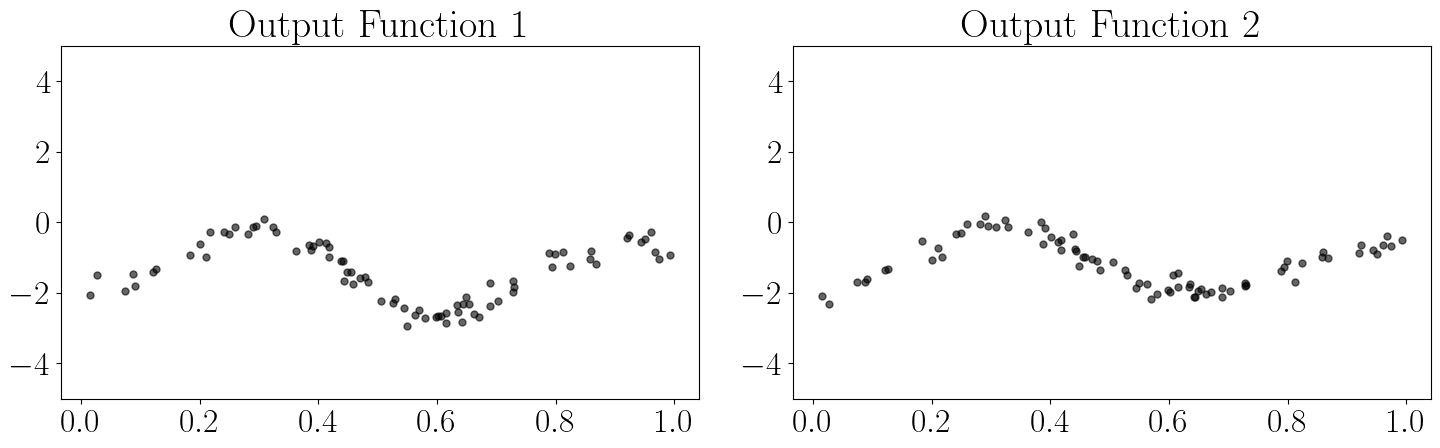

39
[[1.999396 1.200486]
 [1.200486 1.000642]]


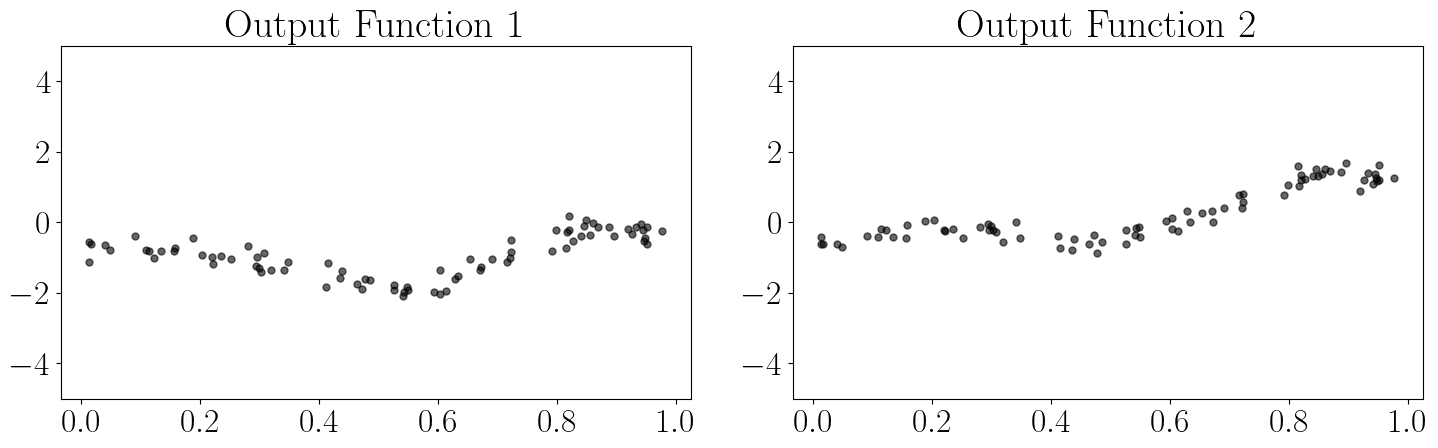

40
[[1.999396 1.200486]
 [1.200486 1.000642]]


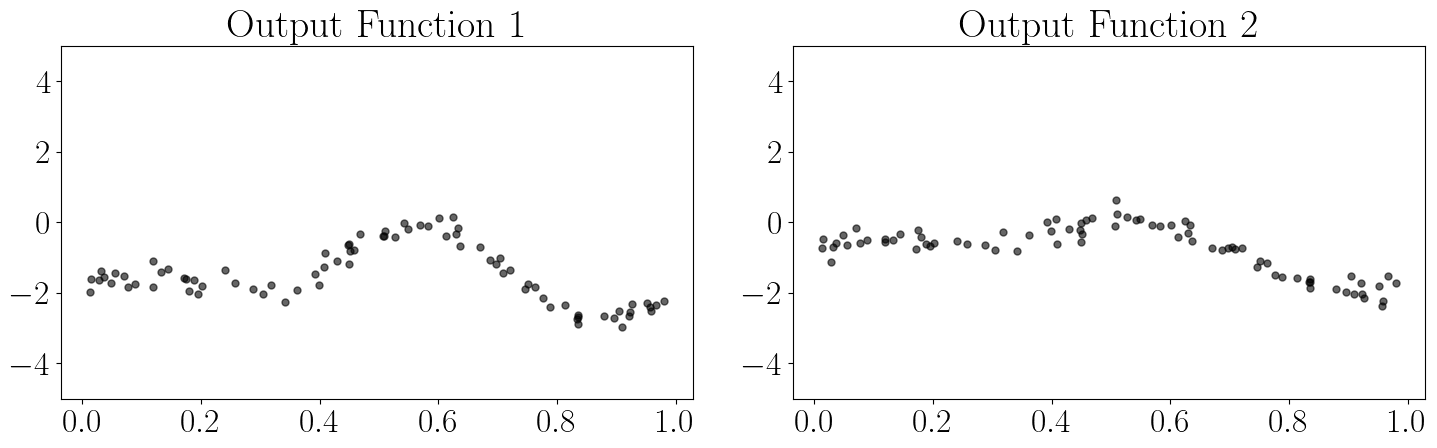

41
[[1.999396 1.200486]
 [1.200486 1.000642]]


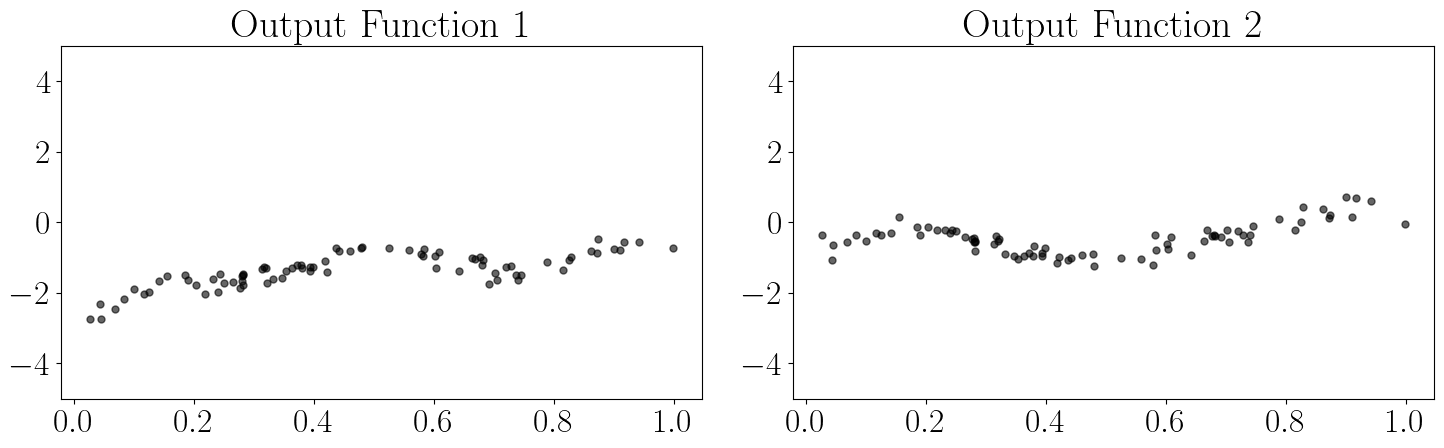

42
[[1.999396 1.200486]
 [1.200486 1.000642]]


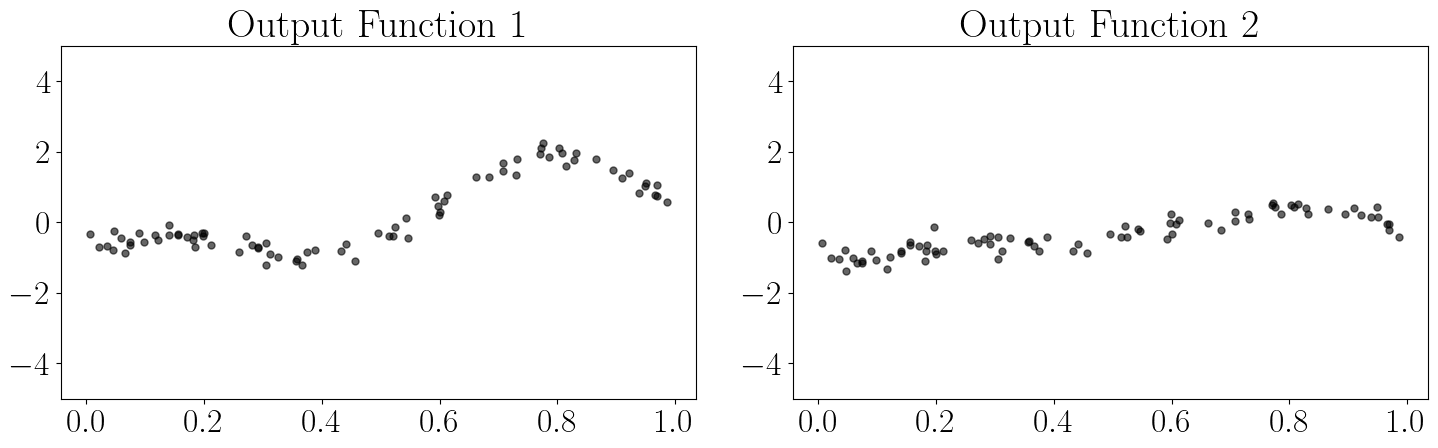

43
[[1.999396 1.200486]
 [1.200486 1.000642]]


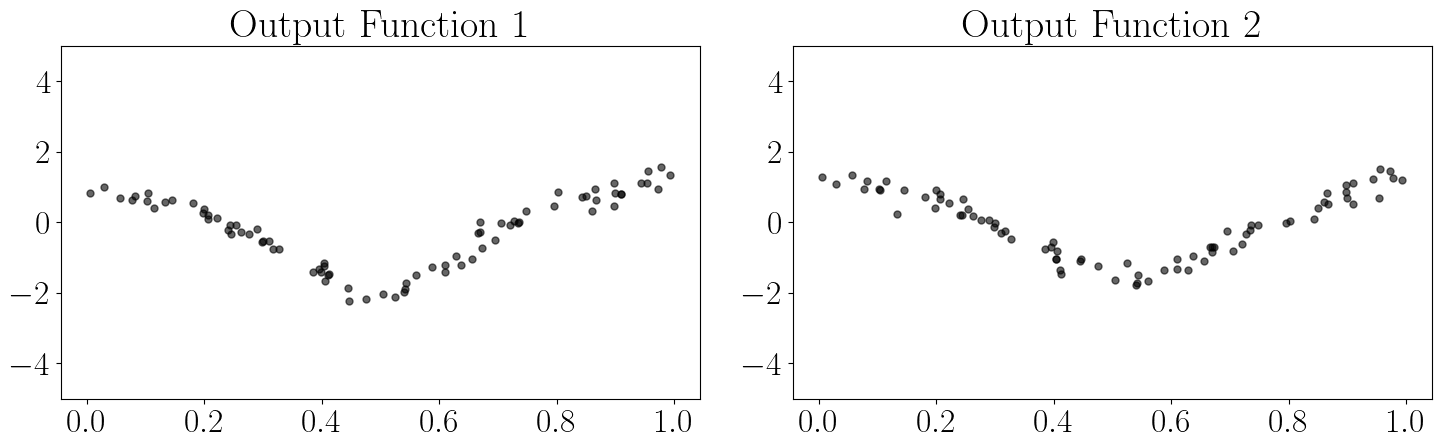

44
[[1.999396 1.200486]
 [1.200486 1.000642]]


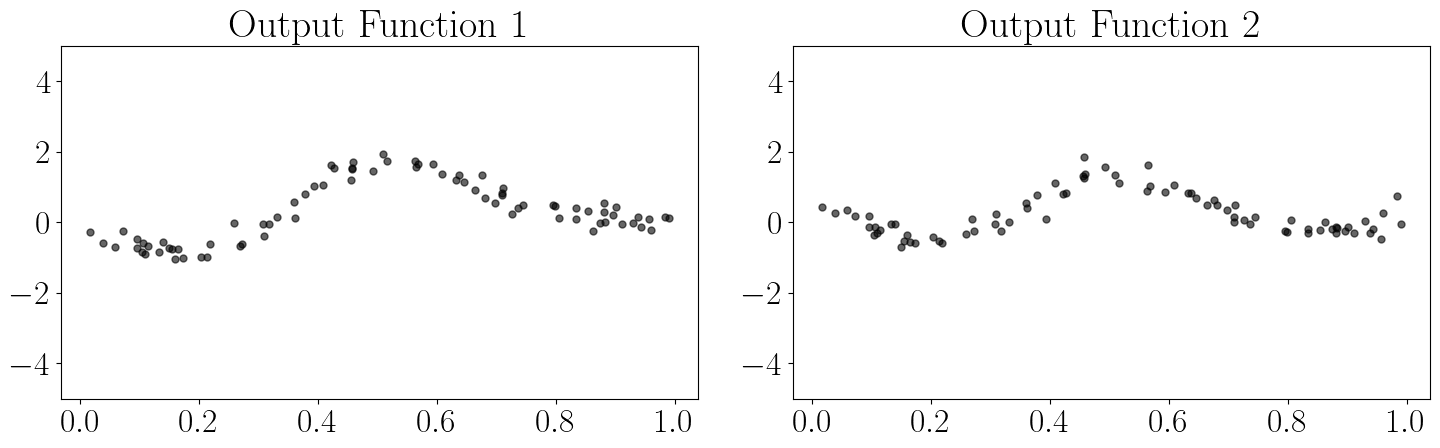

45
[[1.999396 1.200486]
 [1.200486 1.000642]]


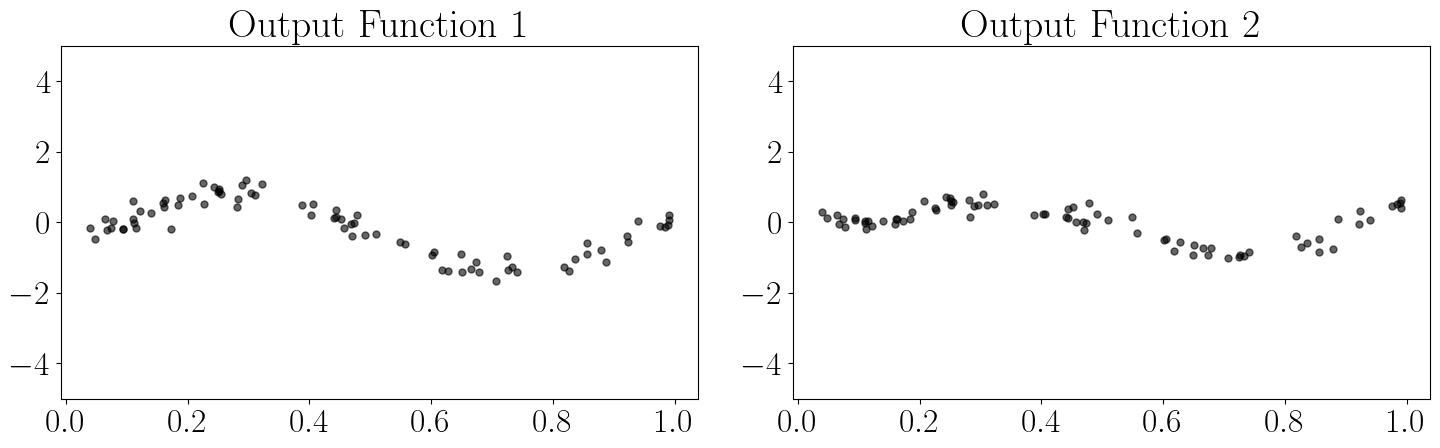

46
[[1.999396 1.200486]
 [1.200486 1.000642]]


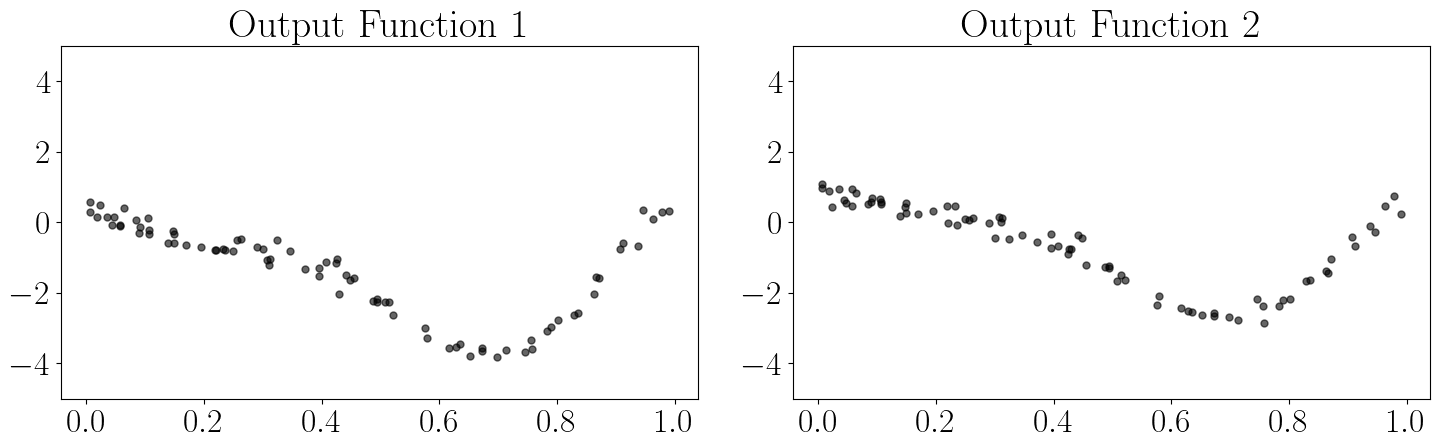

47
[[1.999396 1.200486]
 [1.200486 1.000642]]


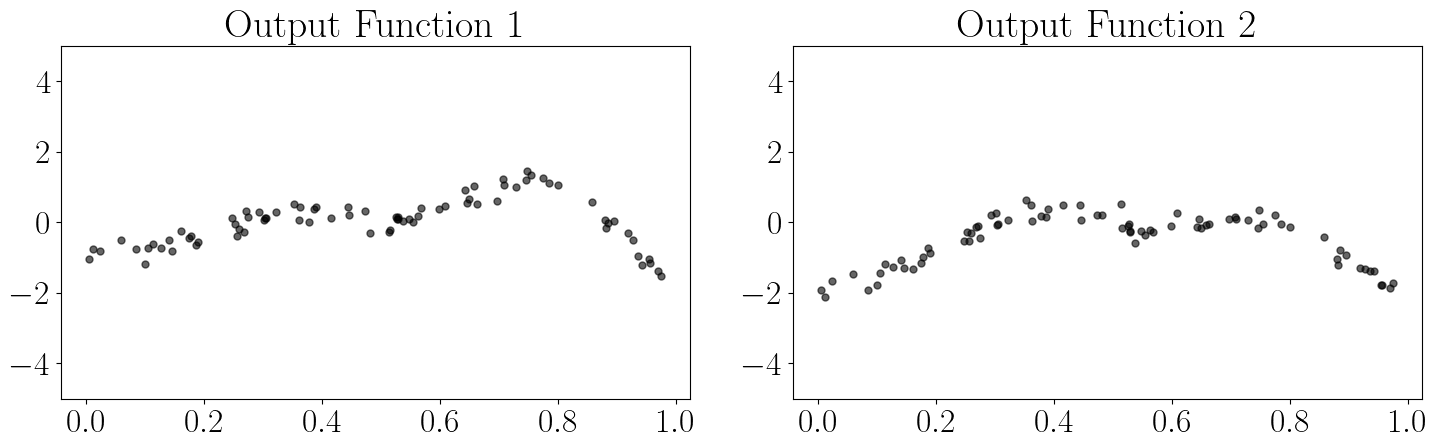

48
[[1.999396 1.200486]
 [1.200486 1.000642]]


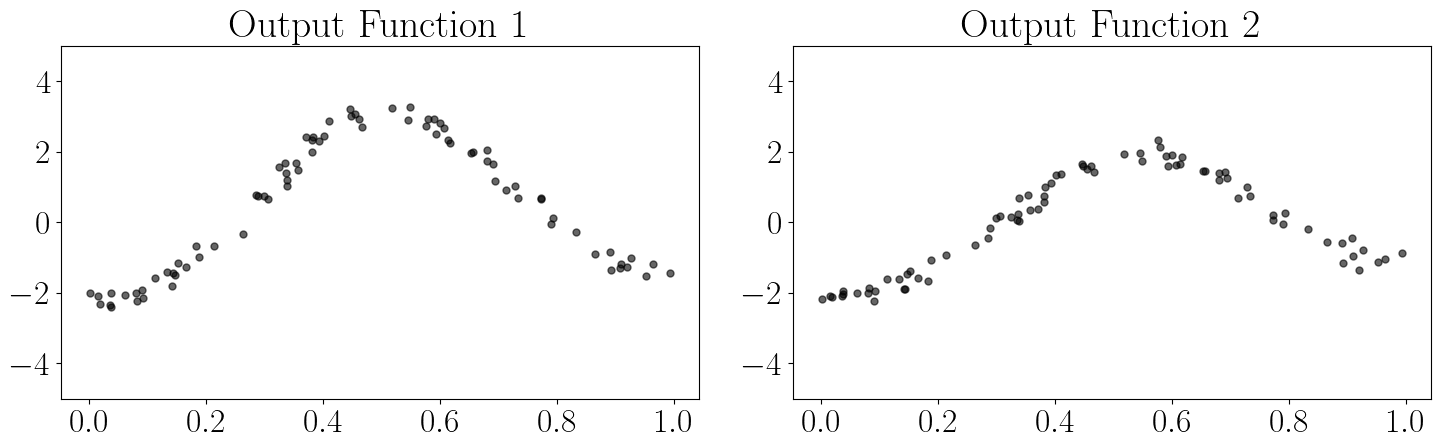

49
[[1.999396 1.200486]
 [1.200486 1.000642]]


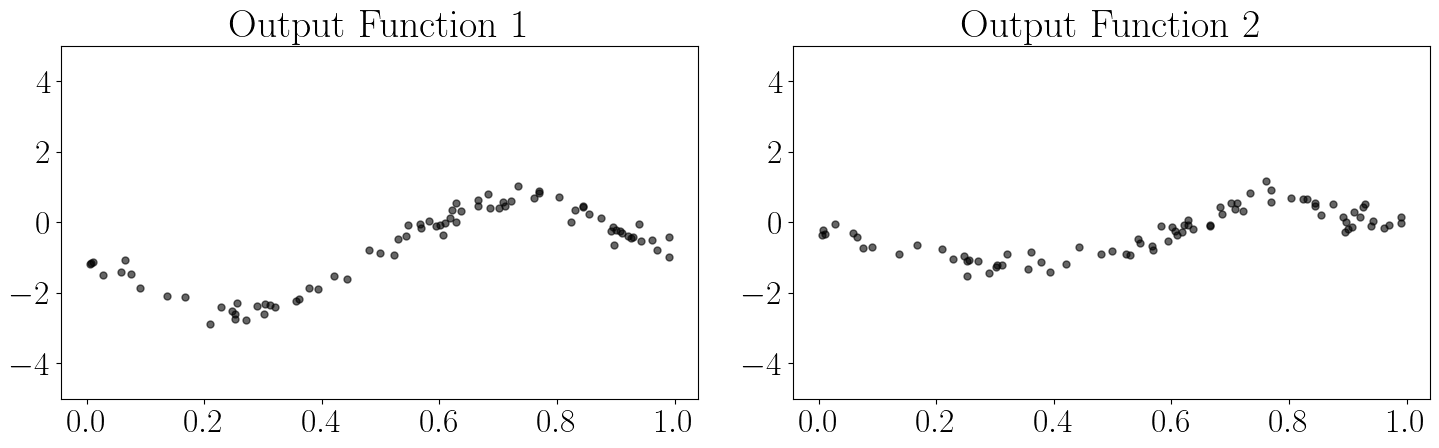

In [43]:
for i in range(50):
    np.random.seed(i)
    print(i)
    # Initialisation
    constant_mean = 0
    length_scale = 0.2
    variance = 1
    n_outputs = 2
    n_points = 120
    overlap_ratio = 1

    noise_variance = 0.04

    A = np.array([[1.414, 0], 
        [0.849, 0.529]])
    B = A @ A.T
    print(B)

    D = B.shape[0]

    # Simulation
    mean_func = ConstantMean(constant=constant_mean)
    rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

    x_train = np.sort(np.random.uniform(0, 1, 80)).reshape(-1, 1)
    N = len(x_train)
    kernel_train = rbf_kernel(x_train, x_train)
    K_train = np.kron(B, kernel_train)
    K_train_noise = K_train + np.kron(noise_variance * np.eye(D), np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
    y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

    y_train = apply_overlap(y_train, overlap_ratio)

    # indices_025 = np.where((x_train >= 0.40) & (x_train <= 0.50))[0]
    # outlier_indices_025 = np.random.choice(indices_025, int(4), replace=False)
    # y_train[outlier_indices_025, 0] = 2

    x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    for i in range(2):
        axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
        axs[i].set_title(f"Output Function {i+1}")
        axs[i].set_ylim([-5, 5])
        # axs[i].legend()

    plt.tight_layout()
    plt.show()

[[1.999396 1.200486]
 [1.200486 1.000642]]


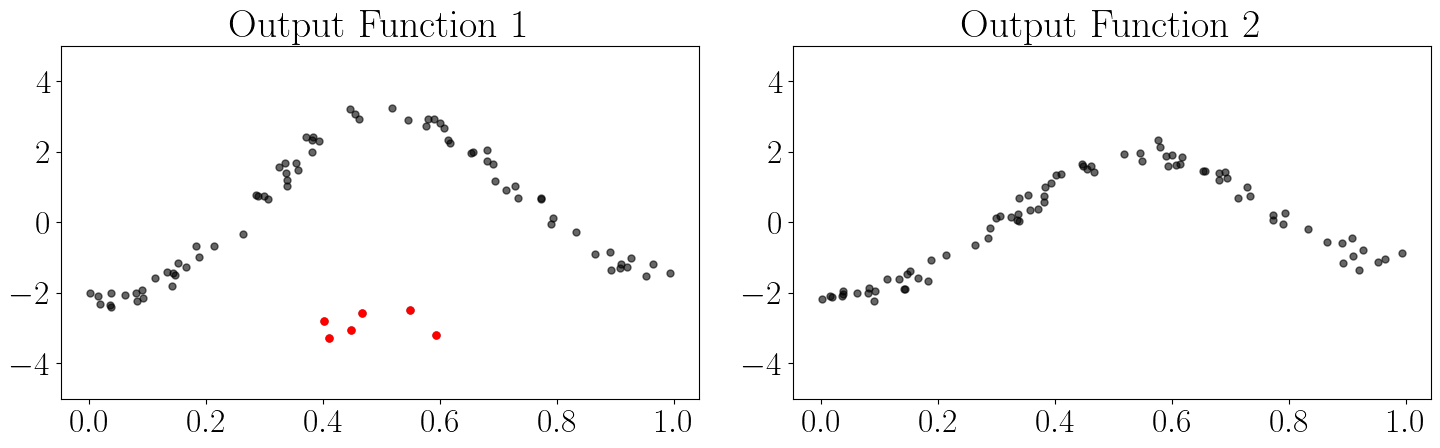

In [50]:
np.random.seed(48)
# Initialisation
epsilon = 0.05
constant_mean = 0
length_scale = 0.2
variance = 1
n_outputs = 2
n_points = 120
overlap_ratio = 1

noise_variance = 0.04

A = np.array([[1.414, 0], 
    [0.849, 0.529]])
B = A @ A.T
print(B)

D = B.shape[0]

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.sort(np.random.uniform(0, 1, 80)).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(noise_variance * np.eye(D), np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_train = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

y_train = apply_overlap(y_train, overlap_ratio)

outlier_range = np.where((x_train >= 0.4) & (x_train <= 0.6))[0]
outlier_indices = np.random.choice(outlier_range, int(epsilon*n_points), replace=False)
y_train[outlier_indices, 0] = np.random.normal(loc=-3, scale=0.5, size=outlier_indices.shape[0])

# Mask to keep all indices that are NOT outliers
mask = np.ones(len(x_train), dtype=bool)
mask[outlier_indices] = False
x_train_no_outliers = x_train[mask]
y_train_no_outliers = y_train[mask]

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
    if i == 0:
        axs[i].plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outlier points')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-5, 5])
    # axs[i].legend()

plt.tight_layout()
plt.show()

In [51]:
# Instantiate and train
mogp = MOGPRegressor(n_outputs = n_outputs, mean = 0, length_scale=0.1, noise = noise_variance, A=A)
mogp.fit(x_train, y_train)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_B = mogp.B
print(optim_B)

Optimized length_scale: 0.1818, noise: 0.996903
Optimized A: [[1.31935837 0.34956907]
 [1.30507084 0.34578117]]
Optimized B: 
[[1.86290504 1.84273054]
 [1.84273054 1.82277452]]
[[1.86290504 1.84273054]
 [1.84273054 1.82277452]]


In [55]:
# Instantiate and train
morcgp = MORCGPRegressor(n_outputs = n_outputs, mean = 0, length_scale=0.1, noise = noise_variance, A=A)
predictive_mean, predictive_variances = morcgp.fit(x_train, y_train)

# print(morcgp.loo_cv(length_scale=0.1, noise=0.04, A=A, weighted=True, B_weighted=B))

# Optimize hyperparameters
morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=True, B_weighted=optim_B)


# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu, var = morcgp.predict(x_test)
std = np.sqrt(var + morcgp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    axs[i].fill_between(x_train.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])

plt.tight_layout()
plt.show()

-1.779792700881004
-1.7797926158016224
-1.7797928211972143
-1.779792821094253
-1.7797926386596594
-1.7797925161646502
-1.7797926894158858
-35.81859846425657
-35.818598465373256
-35.818598672568584
-35.818596894989824
-35.8186001321329
-35.818599416876836
-35.818597523024465
2.9933113335598365
2.9933114071967775
2.993311246026145
2.99331136117908
2.9933113497696997
2.993311310984601
2.9933113041818333
4.780725601955794
4.78072566728413
4.780725547816683
4.780725626061468
4.780725603322736
4.780725577596931
4.780725591215477
6.184815780243626
6.184815792905347
6.1848158567163996


KeyboardInterrupt: 

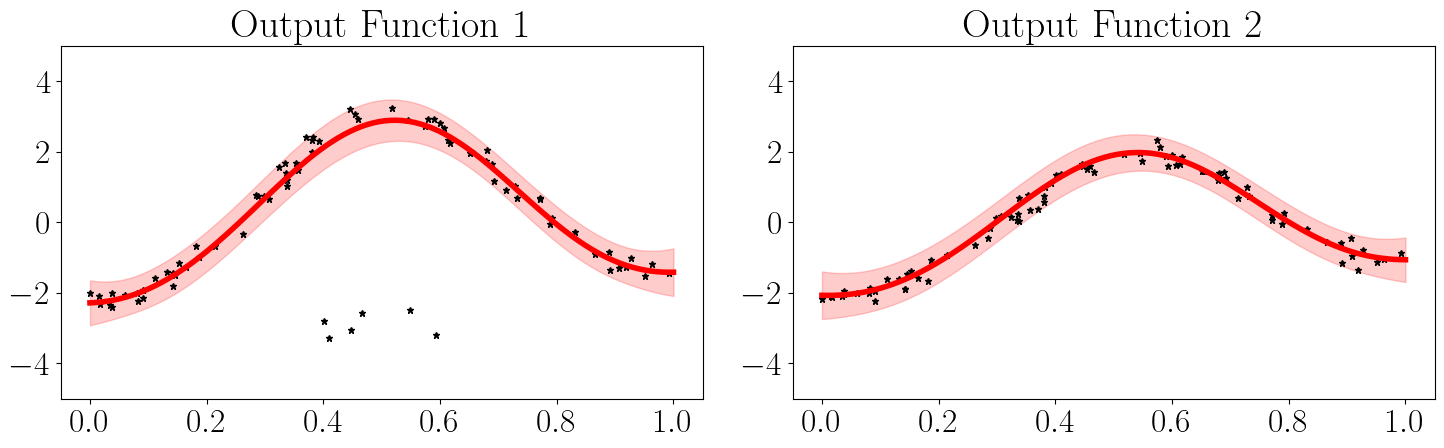

In [56]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'k*', label=f'Observed Data')

    # axs[i].plot(x_train.flatten(), predictive_mean[:, i], '-', color='blue', label=f'Predictive Mean')
    # axs[i].fill_between(x_train.flatten(), predictive_mean[:, i] - np.sqrt(predictive_variances[:, i]), predictive_mean[:, i] + np.sqrt(predictive_variances[:, i]), color='blue', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-5, 5])

plt.tight_layout()
plt.show()